# Learning to Reweight Examples for Robust Deep Learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ML_Project

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project


In [3]:
%cd /content/drive/MyDrive/ML_Project/learning-to-reweight-examples/

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project/learning-to-reweight-examples


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from model import *
from data_loader import *
from wide_resnet import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 5})
import numpy as np
import random
import os
import csv

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
hyperparameters = {
    'lr' : 0.1,
    'momentum' : 0.9,
    'batch_size' : 20,
    'num_iterations' : 100,
}

In [ ]:
# 10 for CIFAR-10 and 100 for CIFAR-100
cifar_num_classes = 10 

n_val will dictate the number of validation images. Since we need 10 clean images from each class, n_val is set to 100% more images than 100 or 1000 to accomodate atleast 10 images in every class. 

Explanation :
if n_val is set to 100, then say class 4 has 12 images in the set, then some other class(es) will contain less than 10 clean images

In [23]:
data_loader = get_cifar_loader(hyperparameters['batch_size'], cifar_type="10",n_val= (20*cifar_num_classes), mode="train", run_type="bkgnd_flip")
test_loader = get_cifar_loader(hyperparameters['batch_size'], cifar_type="10",n_val= (20*cifar_num_classes), mode="test",run_type="bkgnd_flip")

Files already downloaded and verified
50000
bkgnd_flip
torch.Size([200, 3, 32, 32])
torch.Size([200])
Files already downloaded and verified


In [24]:
def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

In [25]:
def build_model_wrn(cifar_type, model_type):
    net = Wide_ResNet(28, 10, 0.3, cifar_type)
    if(model_type == "baseline"):
      if os.path.isfile("cifar_bkgnd_baseline.pt"):
        net.load_state_dict(torch.load('cifar_bkgnd_baseline.pt'))
    elif(model_type == "reweight"):
      if os.path.isfile("cifar_bkgnd_reweight.pt"):
        net.load_state_dict(torch.load('cifar_bkgnd_reweight.pt'))
    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparameters["lr"])
    
    return net, opt

Obtain 10 images of each class from the above 200 val images

In [26]:
temp_val_data = data_loader.dataset.data_val
temp_val_labels = data_loader.dataset.labels_val

val_data = []
val_labels = []

for class_idx in range(0,cifar_num_classes):
  tmp_idx = np.where(temp_val_labels == class_idx)[0]
  np.random.shuffle(tmp_idx)
  tmp_idx = torch.from_numpy(tmp_idx)
  img = temp_val_data[tmp_idx[:10]]
  val_data.append(img)
  cl = temp_val_labels[tmp_idx[:10]]
  val_labels.append(cl)

val_data = torch.cat(val_data, dim=0)
val_labels = torch.cat(val_labels, dim=0)

val_indices = random.sample(list(range(10*cifar_num_classes)),10*cifar_num_classes)
val_data = val_data[val_indices]
val_labels = val_labels[val_indices]

In [27]:
val_data = to_var(val_data, requires_grad=False)
val_labels = to_var(val_labels, requires_grad=False)

In [28]:
print(val_data.shape)

torch.Size([100, 3, 32, 32])


In [29]:
from wide_resnet import Wide_ResNet

def train_lre_cifar_reweight():
    net, opt = build_model_wrn(cifar_type=10,model_type="reweight")
    global val_data
    global val_labels
    net_losses = []
    plot_step = 100

    smoothing_alpha = 0.9
    accuracy_log = []    
    lr_update = 1
    csv_net_losses = []
    csv_acc = []
    if os.path.isfile("acc_log_cifar_bkgnd_flip.csv"):
      with open("acc_log_cifar_bkgnd_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_acc.append(list(np.float_(row)))
      csv_file.close()
      with open("loss_log_cifar_bkgnd_flip.csv", "r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',')
        for row in reader:
          csv_net_losses.append(list(np.float_(row)))
      csv_file.close()

    csv_net_losses = np.array(csv_net_losses)
    csv_acc = np.array(csv_acc)

    for i in tqdm(range(iter_start,iter_end)):
        if i > 40000:
          lr_update = 0.1
        if i > 60000:
          lr_update = 0.01
        opt.param_groups[0]['lr'] = lr_update * hyperparameters['lr']
        net.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = Wide_ResNet(28, 10, 0.3, 10)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False)
        labels = to_var(labels.type(torch.LongTensor), requires_grad=False)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        cost = F.cross_entropy(y_f_hat,labels.type(torch.LongTensor).cuda(), reduce=False)
        eps = to_var(torch.zeros(cost.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()
        
        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(lr_update*hyperparameters['lr'], source_params=grads)
        
        #select 10 images of each class
        y_g_hat = meta_net(val_data)
        l_g_meta = F.cross_entropy(y_g_hat, val_labels)
        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)
        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        cost = F.cross_entropy(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        net_losses.append(l_f.item())

        if i % plot_step == 0:
            net.eval()
            acc = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output = net(test_img)
                output = F.softmax(output, dim = 1)
                predicted = torch.argmax(output, dim = 1).int()
                acc.append((predicted.int() == test_label.int()).float())
            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy.cpu()])[None])

            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            net_losses_plot = np.concatenate((csv_net_losses.flatten(),np.array(net_losses)), axis=0) if csv_net_losses.size else np.array(net_losses)
            ax1.plot(net_losses_plot, label='net_losses_reweighted')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate((csv_acc,np.concatenate(accuracy_log,axis=0)), axis=0) if csv_acc.size else np.concatenate(accuracy_log,axis=0)
            ax2.plot(acc_log[:,0],100*acc_log[:,1],label='accuracy_reweighted')
            ax2.legend()
            ax2.set_ylabel('Accuracy %')
            ax2.set_xlabel('Iteration')
            plt.show()

    torch.save(net.state_dict(), 'cifar_bkgnd_reweight.pt')        
        # return accuracy
    return np.concatenate(accuracy_log,axis=0), np.array(net_losses) 

In [30]:
iter_start = 16000
iter_end = 18000

In [31]:
acc_log, net_losses = train_lre_cifar_reweight()
with open('acc_log_cifar_bkgnd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_cifar_bkgnd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses, delimiter=',',fmt='%s', comments='')
  csvfile.close()

| Wide-Resnet 28x10


  0%|          | 0/1000 [00:00<?, ?it/s]

| Wide-Resnet 28x10


  0%|          | 1/1000 [00:29<8:13:41, 29.65s/it]

| Wide-Resnet 28x10


  0%|          | 2/1000 [00:31<3:37:26, 13.07s/it]

| Wide-Resnet 28x10


  0%|          | 3/1000 [00:32<2:09:12,  7.78s/it]

| Wide-Resnet 28x10


  0%|          | 4/1000 [00:34<1:27:44,  5.29s/it]

| Wide-Resnet 28x10


  0%|          | 5/1000 [00:35<1:04:49,  3.91s/it]

| Wide-Resnet 28x10


  1%|          | 6/1000 [00:36<50:54,  3.07s/it]  

| Wide-Resnet 28x10


  1%|          | 7/1000 [00:38<44:12,  2.67s/it]

| Wide-Resnet 28x10


  1%|          | 8/1000 [00:40<39:33,  2.39s/it]

| Wide-Resnet 28x10


  1%|          | 9/1000 [00:42<34:39,  2.10s/it]

| Wide-Resnet 28x10


  1%|          | 10/1000 [00:43<31:15,  1.89s/it]

| Wide-Resnet 28x10


  1%|          | 11/1000 [00:44<28:55,  1.75s/it]

| Wide-Resnet 28x10


  1%|          | 12/1000 [00:46<27:22,  1.66s/it]

| Wide-Resnet 28x10


  1%|▏         | 13/1000 [00:47<26:08,  1.59s/it]

| Wide-Resnet 28x10


  1%|▏         | 14/1000 [00:49<25:19,  1.54s/it]

| Wide-Resnet 28x10


  2%|▏         | 15/1000 [00:50<24:52,  1.51s/it]

| Wide-Resnet 28x10


  2%|▏         | 16/1000 [00:52<26:07,  1.59s/it]

| Wide-Resnet 28x10


  2%|▏         | 17/1000 [00:54<27:05,  1.65s/it]

| Wide-Resnet 28x10


  2%|▏         | 18/1000 [00:55<25:59,  1.59s/it]

| Wide-Resnet 28x10


  2%|▏         | 19/1000 [00:57<25:12,  1.54s/it]

| Wide-Resnet 28x10


  2%|▏         | 20/1000 [00:58<24:32,  1.50s/it]

| Wide-Resnet 28x10


  2%|▏         | 21/1000 [00:59<24:05,  1.48s/it]

| Wide-Resnet 28x10


  2%|▏         | 22/1000 [01:01<23:45,  1.46s/it]

| Wide-Resnet 28x10


  2%|▏         | 23/1000 [01:02<23:38,  1.45s/it]

| Wide-Resnet 28x10


  2%|▏         | 24/1000 [01:04<23:29,  1.44s/it]

| Wide-Resnet 28x10


  2%|▎         | 25/1000 [01:06<25:04,  1.54s/it]

| Wide-Resnet 28x10


  3%|▎         | 26/1000 [01:07<27:04,  1.67s/it]

| Wide-Resnet 28x10


  3%|▎         | 27/1000 [01:09<25:53,  1.60s/it]

| Wide-Resnet 28x10


  3%|▎         | 28/1000 [01:10<25:00,  1.54s/it]

| Wide-Resnet 28x10


  3%|▎         | 29/1000 [01:12<24:22,  1.51s/it]

| Wide-Resnet 28x10


  3%|▎         | 30/1000 [01:13<24:04,  1.49s/it]

| Wide-Resnet 28x10


  3%|▎         | 31/1000 [01:15<23:46,  1.47s/it]

| Wide-Resnet 28x10


  3%|▎         | 32/1000 [01:16<23:33,  1.46s/it]

| Wide-Resnet 28x10


  3%|▎         | 33/1000 [01:18<24:28,  1.52s/it]

| Wide-Resnet 28x10


  3%|▎         | 34/1000 [01:20<27:55,  1.73s/it]

| Wide-Resnet 28x10


  4%|▎         | 35/1000 [01:22<28:02,  1.74s/it]

| Wide-Resnet 28x10


  4%|▎         | 36/1000 [01:23<26:43,  1.66s/it]

| Wide-Resnet 28x10


  4%|▎         | 37/1000 [01:25<25:35,  1.59s/it]

| Wide-Resnet 28x10


  4%|▍         | 38/1000 [01:26<24:48,  1.55s/it]

| Wide-Resnet 28x10


  4%|▍         | 39/1000 [01:28<24:20,  1.52s/it]

| Wide-Resnet 28x10


  4%|▍         | 40/1000 [01:29<23:57,  1.50s/it]

| Wide-Resnet 28x10


  4%|▍         | 41/1000 [01:30<23:40,  1.48s/it]

| Wide-Resnet 28x10


  4%|▍         | 42/1000 [01:32<23:30,  1.47s/it]

| Wide-Resnet 28x10


  4%|▍         | 43/1000 [01:34<25:05,  1.57s/it]

| Wide-Resnet 28x10


  4%|▍         | 44/1000 [01:35<26:05,  1.64s/it]

| Wide-Resnet 28x10


  4%|▍         | 45/1000 [01:37<25:10,  1.58s/it]

| Wide-Resnet 28x10


  5%|▍         | 46/1000 [01:38<24:27,  1.54s/it]

| Wide-Resnet 28x10


  5%|▍         | 47/1000 [01:40<24:05,  1.52s/it]

| Wide-Resnet 28x10


  5%|▍         | 48/1000 [01:41<23:48,  1.50s/it]

| Wide-Resnet 28x10


  5%|▍         | 49/1000 [01:43<23:27,  1.48s/it]

| Wide-Resnet 28x10


  5%|▌         | 50/1000 [01:44<23:19,  1.47s/it]

| Wide-Resnet 28x10


  5%|▌         | 51/1000 [01:46<23:06,  1.46s/it]

| Wide-Resnet 28x10


  5%|▌         | 52/1000 [01:47<24:39,  1.56s/it]

| Wide-Resnet 28x10


  5%|▌         | 53/1000 [01:49<25:51,  1.64s/it]

| Wide-Resnet 28x10


  5%|▌         | 54/1000 [01:51<24:57,  1.58s/it]

| Wide-Resnet 28x10


  6%|▌         | 55/1000 [01:52<24:15,  1.54s/it]

| Wide-Resnet 28x10


  6%|▌         | 56/1000 [01:54<23:48,  1.51s/it]

| Wide-Resnet 28x10


  6%|▌         | 57/1000 [01:55<23:26,  1.49s/it]

| Wide-Resnet 28x10


  6%|▌         | 58/1000 [01:56<23:06,  1.47s/it]

| Wide-Resnet 28x10


  6%|▌         | 59/1000 [01:58<23:00,  1.47s/it]

| Wide-Resnet 28x10


  6%|▌         | 60/1000 [01:59<22:50,  1.46s/it]

| Wide-Resnet 28x10


  6%|▌         | 61/1000 [02:01<24:31,  1.57s/it]

| Wide-Resnet 28x10


  6%|▌         | 62/1000 [02:03<25:28,  1.63s/it]

| Wide-Resnet 28x10


  6%|▋         | 63/1000 [02:04<24:49,  1.59s/it]

| Wide-Resnet 28x10


  6%|▋         | 64/1000 [02:06<24:14,  1.55s/it]

| Wide-Resnet 28x10


  6%|▋         | 65/1000 [02:07<23:43,  1.52s/it]

| Wide-Resnet 28x10


  7%|▋         | 66/1000 [02:09<23:19,  1.50s/it]

| Wide-Resnet 28x10


  7%|▋         | 67/1000 [02:10<23:05,  1.48s/it]

| Wide-Resnet 28x10


  7%|▋         | 68/1000 [02:12<22:55,  1.48s/it]

| Wide-Resnet 28x10


  7%|▋         | 69/1000 [02:13<22:48,  1.47s/it]

| Wide-Resnet 28x10


  7%|▋         | 70/1000 [02:15<24:17,  1.57s/it]

| Wide-Resnet 28x10


  7%|▋         | 71/1000 [02:17<25:15,  1.63s/it]

| Wide-Resnet 28x10


  7%|▋         | 72/1000 [02:18<24:56,  1.61s/it]

| Wide-Resnet 28x10


  7%|▋         | 73/1000 [02:20<24:05,  1.56s/it]

| Wide-Resnet 28x10


  7%|▋         | 74/1000 [02:21<23:35,  1.53s/it]

| Wide-Resnet 28x10


  8%|▊         | 75/1000 [02:23<23:07,  1.50s/it]

| Wide-Resnet 28x10


  8%|▊         | 76/1000 [02:24<22:48,  1.48s/it]

| Wide-Resnet 28x10


  8%|▊         | 77/1000 [02:25<22:35,  1.47s/it]

| Wide-Resnet 28x10


  8%|▊         | 78/1000 [02:27<22:20,  1.45s/it]

| Wide-Resnet 28x10


  8%|▊         | 79/1000 [02:29<23:26,  1.53s/it]

| Wide-Resnet 28x10


  8%|▊         | 80/1000 [02:30<24:35,  1.60s/it]

| Wide-Resnet 28x10


  8%|▊         | 81/1000 [02:32<24:56,  1.63s/it]

| Wide-Resnet 28x10


  8%|▊         | 82/1000 [02:34<24:04,  1.57s/it]

| Wide-Resnet 28x10


  8%|▊         | 83/1000 [02:35<23:34,  1.54s/it]

| Wide-Resnet 28x10


  8%|▊         | 84/1000 [02:36<23:01,  1.51s/it]

| Wide-Resnet 28x10


  8%|▊         | 85/1000 [02:38<22:40,  1.49s/it]

| Wide-Resnet 28x10


  9%|▊         | 86/1000 [02:39<22:25,  1.47s/it]

| Wide-Resnet 28x10


  9%|▊         | 87/1000 [02:41<22:13,  1.46s/it]

| Wide-Resnet 28x10


  9%|▉         | 88/1000 [02:42<22:44,  1.50s/it]

| Wide-Resnet 28x10


  9%|▉         | 89/1000 [02:44<24:04,  1.59s/it]

| Wide-Resnet 28x10


  9%|▉         | 90/1000 [02:46<25:05,  1.65s/it]

| Wide-Resnet 28x10


  9%|▉         | 91/1000 [02:47<24:09,  1.59s/it]

| Wide-Resnet 28x10


  9%|▉         | 92/1000 [02:49<23:23,  1.55s/it]

| Wide-Resnet 28x10


  9%|▉         | 93/1000 [02:50<22:52,  1.51s/it]

| Wide-Resnet 28x10


  9%|▉         | 94/1000 [02:52<22:30,  1.49s/it]

| Wide-Resnet 28x10


 10%|▉         | 95/1000 [02:53<22:14,  1.47s/it]

| Wide-Resnet 28x10


 10%|▉         | 96/1000 [02:55<22:05,  1.47s/it]

| Wide-Resnet 28x10


 10%|▉         | 97/1000 [02:56<22:19,  1.48s/it]

| Wide-Resnet 28x10


 10%|▉         | 98/1000 [02:58<23:40,  1.58s/it]

| Wide-Resnet 28x10


 10%|▉         | 99/1000 [03:00<24:38,  1.64s/it]

| Wide-Resnet 28x10


 10%|█         | 100/1000 [03:01<23:43,  1.58s/it]

| Wide-Resnet 28x10


 10%|█         | 101/1000 [03:03<23:05,  1.54s/it]

| Wide-Resnet 28x10


 10%|█         | 102/1000 [03:04<22:38,  1.51s/it]

| Wide-Resnet 28x10


 10%|█         | 103/1000 [03:05<22:19,  1.49s/it]

| Wide-Resnet 28x10


 10%|█         | 104/1000 [03:07<22:03,  1.48s/it]

| Wide-Resnet 28x10


 10%|█         | 105/1000 [03:08<21:50,  1.46s/it]

| Wide-Resnet 28x10


 11%|█         | 106/1000 [03:10<21:42,  1.46s/it]

| Wide-Resnet 28x10


 11%|█         | 107/1000 [03:12<23:06,  1.55s/it]

| Wide-Resnet 28x10


 11%|█         | 108/1000 [03:13<24:04,  1.62s/it]

| Wide-Resnet 28x10


 11%|█         | 109/1000 [03:15<23:09,  1.56s/it]

| Wide-Resnet 28x10


 11%|█         | 110/1000 [03:16<22:45,  1.53s/it]

| Wide-Resnet 28x10


 11%|█         | 111/1000 [03:18<22:17,  1.50s/it]

| Wide-Resnet 28x10


 11%|█         | 112/1000 [03:19<22:01,  1.49s/it]

| Wide-Resnet 28x10


 11%|█▏        | 113/1000 [03:21<21:46,  1.47s/it]

| Wide-Resnet 28x10


 11%|█▏        | 114/1000 [03:22<21:40,  1.47s/it]

| Wide-Resnet 28x10


 12%|█▏        | 115/1000 [03:23<21:36,  1.46s/it]

| Wide-Resnet 28x10


 12%|█▏        | 116/1000 [03:25<23:00,  1.56s/it]

| Wide-Resnet 28x10


 12%|█▏        | 117/1000 [03:27<24:00,  1.63s/it]

| Wide-Resnet 28x10


 12%|█▏        | 118/1000 [03:28<23:10,  1.58s/it]

| Wide-Resnet 28x10


 12%|█▏        | 119/1000 [03:30<22:31,  1.53s/it]

| Wide-Resnet 28x10


 12%|█▏        | 120/1000 [03:31<22:05,  1.51s/it]

| Wide-Resnet 28x10


 12%|█▏        | 121/1000 [03:33<21:51,  1.49s/it]

| Wide-Resnet 28x10


 12%|█▏        | 122/1000 [03:34<21:39,  1.48s/it]

| Wide-Resnet 28x10


 12%|█▏        | 123/1000 [03:36<21:31,  1.47s/it]

| Wide-Resnet 28x10


 12%|█▏        | 124/1000 [03:37<21:20,  1.46s/it]

| Wide-Resnet 28x10


 12%|█▎        | 125/1000 [03:39<22:43,  1.56s/it]

| Wide-Resnet 28x10


 13%|█▎        | 126/1000 [03:41<23:47,  1.63s/it]

| Wide-Resnet 28x10


 13%|█▎        | 127/1000 [03:42<22:58,  1.58s/it]

| Wide-Resnet 28x10


 13%|█▎        | 128/1000 [03:44<22:16,  1.53s/it]

| Wide-Resnet 28x10


 13%|█▎        | 129/1000 [03:45<21:54,  1.51s/it]

| Wide-Resnet 28x10


 13%|█▎        | 130/1000 [03:47<21:45,  1.50s/it]

| Wide-Resnet 28x10


 13%|█▎        | 131/1000 [03:48<21:26,  1.48s/it]

| Wide-Resnet 28x10


 13%|█▎        | 132/1000 [03:49<21:13,  1.47s/it]

| Wide-Resnet 28x10


 13%|█▎        | 133/1000 [03:51<21:09,  1.46s/it]

| Wide-Resnet 28x10


 13%|█▎        | 134/1000 [03:53<22:35,  1.57s/it]

| Wide-Resnet 28x10


 14%|█▎        | 135/1000 [03:54<23:35,  1.64s/it]

| Wide-Resnet 28x10


 14%|█▎        | 136/1000 [03:56<23:08,  1.61s/it]

| Wide-Resnet 28x10


 14%|█▎        | 137/1000 [03:57<22:31,  1.57s/it]

| Wide-Resnet 28x10


 14%|█▍        | 138/1000 [03:59<21:57,  1.53s/it]

| Wide-Resnet 28x10


 14%|█▍        | 139/1000 [04:00<21:36,  1.51s/it]

| Wide-Resnet 28x10


 14%|█▍        | 140/1000 [04:02<21:20,  1.49s/it]

| Wide-Resnet 28x10


 14%|█▍        | 141/1000 [04:03<21:06,  1.47s/it]

| Wide-Resnet 28x10


 14%|█▍        | 142/1000 [04:05<21:00,  1.47s/it]

| Wide-Resnet 28x10


 14%|█▍        | 143/1000 [04:07<22:28,  1.57s/it]

| Wide-Resnet 28x10


 14%|█▍        | 144/1000 [04:08<23:13,  1.63s/it]

| Wide-Resnet 28x10


 14%|█▍        | 145/1000 [04:10<22:59,  1.61s/it]

| Wide-Resnet 28x10


 15%|█▍        | 146/1000 [04:11<22:11,  1.56s/it]

| Wide-Resnet 28x10


 15%|█▍        | 147/1000 [04:13<21:38,  1.52s/it]

| Wide-Resnet 28x10


 15%|█▍        | 148/1000 [04:14<21:15,  1.50s/it]

| Wide-Resnet 28x10


 15%|█▍        | 149/1000 [04:16<20:58,  1.48s/it]

| Wide-Resnet 28x10


 15%|█▌        | 150/1000 [04:17<20:50,  1.47s/it]

| Wide-Resnet 28x10


 15%|█▌        | 151/1000 [04:19<20:40,  1.46s/it]

| Wide-Resnet 28x10


 15%|█▌        | 152/1000 [04:20<21:38,  1.53s/it]

| Wide-Resnet 28x10


 15%|█▌        | 153/1000 [04:22<22:39,  1.61s/it]

| Wide-Resnet 28x10


 15%|█▌        | 154/1000 [04:24<23:08,  1.64s/it]

| Wide-Resnet 28x10


 16%|█▌        | 155/1000 [04:25<22:21,  1.59s/it]

| Wide-Resnet 28x10


 16%|█▌        | 156/1000 [04:27<21:40,  1.54s/it]

| Wide-Resnet 28x10


 16%|█▌        | 157/1000 [04:28<21:19,  1.52s/it]

| Wide-Resnet 28x10


 16%|█▌        | 158/1000 [04:30<21:03,  1.50s/it]

| Wide-Resnet 28x10


 16%|█▌        | 159/1000 [04:31<20:46,  1.48s/it]

| Wide-Resnet 28x10


 16%|█▌        | 160/1000 [04:32<20:38,  1.47s/it]

| Wide-Resnet 28x10


 16%|█▌        | 161/1000 [04:34<21:17,  1.52s/it]

| Wide-Resnet 28x10


 16%|█▌        | 162/1000 [04:36<22:29,  1.61s/it]

| Wide-Resnet 28x10


 16%|█▋        | 163/1000 [04:38<23:03,  1.65s/it]

| Wide-Resnet 28x10


 16%|█▋        | 164/1000 [04:39<22:06,  1.59s/it]

| Wide-Resnet 28x10


 16%|█▋        | 165/1000 [04:41<21:29,  1.54s/it]

| Wide-Resnet 28x10


 17%|█▋        | 166/1000 [04:42<21:08,  1.52s/it]

| Wide-Resnet 28x10


 17%|█▋        | 167/1000 [04:43<20:44,  1.49s/it]

| Wide-Resnet 28x10


 17%|█▋        | 168/1000 [04:45<20:39,  1.49s/it]

| Wide-Resnet 28x10


 17%|█▋        | 169/1000 [04:46<20:28,  1.48s/it]

| Wide-Resnet 28x10


 17%|█▋        | 170/1000 [04:48<20:51,  1.51s/it]

| Wide-Resnet 28x10


 17%|█▋        | 171/1000 [04:50<21:56,  1.59s/it]

| Wide-Resnet 28x10


 17%|█▋        | 172/1000 [04:51<22:46,  1.65s/it]

| Wide-Resnet 28x10


 17%|█▋        | 173/1000 [04:53<21:51,  1.59s/it]

| Wide-Resnet 28x10


 17%|█▋        | 174/1000 [04:54<21:16,  1.55s/it]

| Wide-Resnet 28x10


 18%|█▊        | 175/1000 [04:56<20:48,  1.51s/it]

| Wide-Resnet 28x10


 18%|█▊        | 176/1000 [04:57<20:32,  1.50s/it]

| Wide-Resnet 28x10


 18%|█▊        | 177/1000 [04:59<20:15,  1.48s/it]

| Wide-Resnet 28x10


 18%|█▊        | 178/1000 [05:00<20:09,  1.47s/it]

| Wide-Resnet 28x10


 18%|█▊        | 179/1000 [05:02<20:12,  1.48s/it]

| Wide-Resnet 28x10


 18%|█▊        | 180/1000 [05:03<21:24,  1.57s/it]

| Wide-Resnet 28x10


 18%|█▊        | 181/1000 [05:05<22:26,  1.64s/it]

| Wide-Resnet 28x10


 18%|█▊        | 182/1000 [05:07<21:40,  1.59s/it]

| Wide-Resnet 28x10


 18%|█▊        | 183/1000 [05:08<21:06,  1.55s/it]

| Wide-Resnet 28x10


 18%|█▊        | 184/1000 [05:10<20:36,  1.52s/it]

| Wide-Resnet 28x10


 18%|█▊        | 185/1000 [05:11<20:17,  1.49s/it]

| Wide-Resnet 28x10


 19%|█▊        | 186/1000 [05:12<20:04,  1.48s/it]

| Wide-Resnet 28x10


 19%|█▊        | 187/1000 [05:14<19:56,  1.47s/it]

| Wide-Resnet 28x10


 19%|█▉        | 188/1000 [05:15<19:42,  1.46s/it]

| Wide-Resnet 28x10


 19%|█▉        | 189/1000 [05:17<21:04,  1.56s/it]

| Wide-Resnet 28x10


 19%|█▉        | 190/1000 [05:19<21:59,  1.63s/it]

| Wide-Resnet 28x10


 19%|█▉        | 191/1000 [05:20<21:11,  1.57s/it]

| Wide-Resnet 28x10


 19%|█▉        | 192/1000 [05:22<20:36,  1.53s/it]

| Wide-Resnet 28x10


 19%|█▉        | 193/1000 [05:23<20:17,  1.51s/it]

| Wide-Resnet 28x10


 19%|█▉        | 194/1000 [05:25<20:37,  1.54s/it]

| Wide-Resnet 28x10


 20%|█▉        | 195/1000 [05:26<20:16,  1.51s/it]

| Wide-Resnet 28x10


 20%|█▉        | 196/1000 [05:28<19:56,  1.49s/it]

| Wide-Resnet 28x10


 20%|█▉        | 197/1000 [05:29<19:47,  1.48s/it]

| Wide-Resnet 28x10


 20%|█▉        | 198/1000 [05:31<21:09,  1.58s/it]

| Wide-Resnet 28x10


 20%|█▉        | 199/1000 [05:33<22:00,  1.65s/it]

| Wide-Resnet 28x10


 20%|██        | 200/1000 [05:34<21:08,  1.59s/it]

| Wide-Resnet 28x10


 20%|██        | 201/1000 [06:03<2:11:05,  9.84s/it]

| Wide-Resnet 28x10


 20%|██        | 202/1000 [06:05<1:37:24,  7.32s/it]

| Wide-Resnet 28x10


 20%|██        | 203/1000 [06:06<1:13:54,  5.56s/it]

| Wide-Resnet 28x10


 20%|██        | 204/1000 [06:08<57:23,  4.33s/it]  

| Wide-Resnet 28x10


 20%|██        | 205/1000 [06:09<45:49,  3.46s/it]

| Wide-Resnet 28x10


 21%|██        | 206/1000 [06:11<37:56,  2.87s/it]

| Wide-Resnet 28x10


 21%|██        | 207/1000 [06:13<34:40,  2.62s/it]

| Wide-Resnet 28x10


 21%|██        | 208/1000 [06:15<31:21,  2.38s/it]

| Wide-Resnet 28x10


 21%|██        | 209/1000 [06:16<27:30,  2.09s/it]

| Wide-Resnet 28x10


 21%|██        | 210/1000 [06:17<24:53,  1.89s/it]

| Wide-Resnet 28x10


 21%|██        | 211/1000 [06:19<23:03,  1.75s/it]

| Wide-Resnet 28x10


 21%|██        | 212/1000 [06:20<21:44,  1.66s/it]

| Wide-Resnet 28x10


 21%|██▏       | 213/1000 [06:22<20:47,  1.58s/it]

| Wide-Resnet 28x10


 21%|██▏       | 214/1000 [06:23<20:08,  1.54s/it]

| Wide-Resnet 28x10


 22%|██▏       | 215/1000 [06:24<19:39,  1.50s/it]

| Wide-Resnet 28x10


 22%|██▏       | 216/1000 [06:26<20:51,  1.60s/it]

| Wide-Resnet 28x10


 22%|██▏       | 217/1000 [06:28<21:31,  1.65s/it]

| Wide-Resnet 28x10


 22%|██▏       | 218/1000 [06:30<20:49,  1.60s/it]

| Wide-Resnet 28x10


 22%|██▏       | 219/1000 [06:31<20:09,  1.55s/it]

| Wide-Resnet 28x10


 22%|██▏       | 220/1000 [06:32<19:42,  1.52s/it]

| Wide-Resnet 28x10


 22%|██▏       | 221/1000 [06:34<19:18,  1.49s/it]

| Wide-Resnet 28x10


 22%|██▏       | 222/1000 [06:35<19:06,  1.47s/it]

| Wide-Resnet 28x10


 22%|██▏       | 223/1000 [06:37<18:59,  1.47s/it]

| Wide-Resnet 28x10


 22%|██▏       | 224/1000 [06:38<18:48,  1.45s/it]

| Wide-Resnet 28x10


 22%|██▎       | 225/1000 [06:40<19:53,  1.54s/it]

| Wide-Resnet 28x10


 23%|██▎       | 226/1000 [06:42<20:53,  1.62s/it]

| Wide-Resnet 28x10


 23%|██▎       | 227/1000 [06:43<20:56,  1.63s/it]

| Wide-Resnet 28x10


 23%|██▎       | 228/1000 [06:45<20:16,  1.58s/it]

| Wide-Resnet 28x10


 23%|██▎       | 229/1000 [06:46<19:42,  1.53s/it]

| Wide-Resnet 28x10


 23%|██▎       | 230/1000 [06:48<19:23,  1.51s/it]

| Wide-Resnet 28x10


 23%|██▎       | 231/1000 [06:49<19:05,  1.49s/it]

| Wide-Resnet 28x10


 23%|██▎       | 232/1000 [06:51<18:51,  1.47s/it]

| Wide-Resnet 28x10


 23%|██▎       | 233/1000 [06:52<18:43,  1.46s/it]

| Wide-Resnet 28x10


 23%|██▎       | 234/1000 [06:54<19:22,  1.52s/it]

| Wide-Resnet 28x10


 24%|██▎       | 235/1000 [06:55<20:30,  1.61s/it]

| Wide-Resnet 28x10


 24%|██▎       | 236/1000 [06:57<20:48,  1.63s/it]

| Wide-Resnet 28x10


 24%|██▎       | 237/1000 [06:59<20:05,  1.58s/it]

| Wide-Resnet 28x10


 24%|██▍       | 238/1000 [07:00<19:45,  1.56s/it]

| Wide-Resnet 28x10


 24%|██▍       | 239/1000 [07:02<19:24,  1.53s/it]

| Wide-Resnet 28x10


 24%|██▍       | 240/1000 [07:03<19:05,  1.51s/it]

| Wide-Resnet 28x10


 24%|██▍       | 241/1000 [07:05<18:52,  1.49s/it]

| Wide-Resnet 28x10


 24%|██▍       | 242/1000 [07:06<18:40,  1.48s/it]

| Wide-Resnet 28x10


 24%|██▍       | 243/1000 [07:08<19:27,  1.54s/it]

| Wide-Resnet 28x10


 24%|██▍       | 244/1000 [07:10<20:34,  1.63s/it]

| Wide-Resnet 28x10


 24%|██▍       | 245/1000 [07:11<20:42,  1.65s/it]

| Wide-Resnet 28x10


 25%|██▍       | 246/1000 [07:13<19:58,  1.59s/it]

| Wide-Resnet 28x10


 25%|██▍       | 247/1000 [07:14<19:31,  1.56s/it]

| Wide-Resnet 28x10


 25%|██▍       | 248/1000 [07:16<19:08,  1.53s/it]

| Wide-Resnet 28x10


 25%|██▍       | 249/1000 [07:17<18:53,  1.51s/it]

| Wide-Resnet 28x10


 25%|██▌       | 250/1000 [07:18<18:32,  1.48s/it]

| Wide-Resnet 28x10


 25%|██▌       | 251/1000 [07:20<18:21,  1.47s/it]

| Wide-Resnet 28x10


 25%|██▌       | 252/1000 [07:22<19:15,  1.54s/it]

| Wide-Resnet 28x10


 25%|██▌       | 253/1000 [07:23<20:09,  1.62s/it]

| Wide-Resnet 28x10


 25%|██▌       | 254/1000 [07:25<20:29,  1.65s/it]

| Wide-Resnet 28x10


 26%|██▌       | 255/1000 [07:27<19:45,  1.59s/it]

| Wide-Resnet 28x10


 26%|██▌       | 256/1000 [07:28<19:13,  1.55s/it]

| Wide-Resnet 28x10


 26%|██▌       | 257/1000 [07:29<18:50,  1.52s/it]

| Wide-Resnet 28x10


 26%|██▌       | 258/1000 [07:31<18:30,  1.50s/it]

| Wide-Resnet 28x10


 26%|██▌       | 259/1000 [07:32<18:19,  1.48s/it]

| Wide-Resnet 28x10


 26%|██▌       | 260/1000 [07:34<18:08,  1.47s/it]

| Wide-Resnet 28x10


 26%|██▌       | 261/1000 [07:35<18:37,  1.51s/it]

| Wide-Resnet 28x10


 26%|██▌       | 262/1000 [07:37<19:35,  1.59s/it]

| Wide-Resnet 28x10


 26%|██▋       | 263/1000 [07:39<20:16,  1.65s/it]

| Wide-Resnet 28x10


 26%|██▋       | 264/1000 [07:40<19:29,  1.59s/it]

| Wide-Resnet 28x10


 26%|██▋       | 265/1000 [07:42<18:56,  1.55s/it]

| Wide-Resnet 28x10


 27%|██▋       | 266/1000 [07:43<18:36,  1.52s/it]

| Wide-Resnet 28x10


 27%|██▋       | 267/1000 [07:45<18:19,  1.50s/it]

| Wide-Resnet 28x10


 27%|██▋       | 268/1000 [07:46<18:08,  1.49s/it]

| Wide-Resnet 28x10


 27%|██▋       | 269/1000 [07:48<17:54,  1.47s/it]

| Wide-Resnet 28x10


 27%|██▋       | 270/1000 [07:49<18:11,  1.49s/it]

| Wide-Resnet 28x10


 27%|██▋       | 271/1000 [07:51<19:16,  1.59s/it]

| Wide-Resnet 28x10


 27%|██▋       | 272/1000 [07:53<20:00,  1.65s/it]

| Wide-Resnet 28x10


 27%|██▋       | 273/1000 [07:54<19:16,  1.59s/it]

| Wide-Resnet 28x10


 27%|██▋       | 274/1000 [07:56<18:44,  1.55s/it]

| Wide-Resnet 28x10


 28%|██▊       | 275/1000 [07:57<18:22,  1.52s/it]

| Wide-Resnet 28x10


 28%|██▊       | 276/1000 [07:59<18:05,  1.50s/it]

| Wide-Resnet 28x10


 28%|██▊       | 277/1000 [08:00<18:00,  1.49s/it]

| Wide-Resnet 28x10


 28%|██▊       | 278/1000 [08:02<17:50,  1.48s/it]

| Wide-Resnet 28x10


 28%|██▊       | 279/1000 [08:03<17:53,  1.49s/it]

| Wide-Resnet 28x10


 28%|██▊       | 280/1000 [08:05<18:59,  1.58s/it]

| Wide-Resnet 28x10


 28%|██▊       | 281/1000 [08:07<19:56,  1.66s/it]

| Wide-Resnet 28x10


 28%|██▊       | 282/1000 [08:08<19:05,  1.60s/it]

| Wide-Resnet 28x10


 28%|██▊       | 283/1000 [08:10<18:31,  1.55s/it]

| Wide-Resnet 28x10


 28%|██▊       | 284/1000 [08:11<18:12,  1.53s/it]

| Wide-Resnet 28x10


 28%|██▊       | 285/1000 [08:13<17:53,  1.50s/it]

| Wide-Resnet 28x10


 29%|██▊       | 286/1000 [08:14<17:46,  1.49s/it]

| Wide-Resnet 28x10


 29%|██▊       | 287/1000 [08:15<17:35,  1.48s/it]

| Wide-Resnet 28x10


 29%|██▉       | 288/1000 [08:17<17:36,  1.48s/it]

| Wide-Resnet 28x10


 29%|██▉       | 289/1000 [08:19<18:37,  1.57s/it]

| Wide-Resnet 28x10


 29%|██▉       | 290/1000 [08:21<19:19,  1.63s/it]

| Wide-Resnet 28x10


 29%|██▉       | 291/1000 [08:22<18:35,  1.57s/it]

| Wide-Resnet 28x10


 29%|██▉       | 292/1000 [08:23<18:08,  1.54s/it]

| Wide-Resnet 28x10


 29%|██▉       | 293/1000 [08:25<17:50,  1.51s/it]

| Wide-Resnet 28x10


 29%|██▉       | 294/1000 [08:26<17:38,  1.50s/it]

| Wide-Resnet 28x10


 30%|██▉       | 295/1000 [08:28<17:26,  1.48s/it]

| Wide-Resnet 28x10


 30%|██▉       | 296/1000 [08:29<17:17,  1.47s/it]

| Wide-Resnet 28x10


 30%|██▉       | 297/1000 [08:31<17:07,  1.46s/it]

| Wide-Resnet 28x10


 30%|██▉       | 298/1000 [08:32<18:20,  1.57s/it]

| Wide-Resnet 28x10


 30%|██▉       | 299/1000 [08:34<19:15,  1.65s/it]

| Wide-Resnet 28x10


 30%|███       | 300/1000 [08:36<18:33,  1.59s/it]

| Wide-Resnet 28x10


 30%|███       | 301/1000 [08:37<17:57,  1.54s/it]

| Wide-Resnet 28x10


 30%|███       | 302/1000 [08:39<17:37,  1.52s/it]

| Wide-Resnet 28x10


 30%|███       | 303/1000 [08:40<17:21,  1.49s/it]

| Wide-Resnet 28x10


 30%|███       | 304/1000 [08:42<17:11,  1.48s/it]

| Wide-Resnet 28x10


 30%|███       | 305/1000 [08:43<17:04,  1.47s/it]

| Wide-Resnet 28x10


 31%|███       | 306/1000 [08:44<16:59,  1.47s/it]

| Wide-Resnet 28x10


 31%|███       | 307/1000 [08:46<18:04,  1.56s/it]

| Wide-Resnet 28x10


 31%|███       | 308/1000 [08:48<18:52,  1.64s/it]

| Wide-Resnet 28x10


 31%|███       | 309/1000 [08:49<18:09,  1.58s/it]

| Wide-Resnet 28x10


 31%|███       | 310/1000 [08:51<17:37,  1.53s/it]

| Wide-Resnet 28x10


 31%|███       | 311/1000 [08:52<17:15,  1.50s/it]

| Wide-Resnet 28x10


 31%|███       | 312/1000 [08:54<17:05,  1.49s/it]

| Wide-Resnet 28x10


 31%|███▏      | 313/1000 [08:55<16:55,  1.48s/it]

| Wide-Resnet 28x10


 31%|███▏      | 314/1000 [08:57<16:45,  1.47s/it]

| Wide-Resnet 28x10


 32%|███▏      | 315/1000 [08:58<16:46,  1.47s/it]

| Wide-Resnet 28x10


 32%|███▏      | 316/1000 [09:00<17:57,  1.58s/it]

| Wide-Resnet 28x10


 32%|███▏      | 317/1000 [09:02<18:41,  1.64s/it]

| Wide-Resnet 28x10


 32%|███▏      | 318/1000 [09:03<18:01,  1.59s/it]

| Wide-Resnet 28x10


 32%|███▏      | 319/1000 [09:05<17:30,  1.54s/it]

| Wide-Resnet 28x10


 32%|███▏      | 320/1000 [09:06<17:15,  1.52s/it]

| Wide-Resnet 28x10


 32%|███▏      | 321/1000 [09:08<17:00,  1.50s/it]

| Wide-Resnet 28x10


 32%|███▏      | 322/1000 [09:09<16:52,  1.49s/it]

| Wide-Resnet 28x10


 32%|███▏      | 323/1000 [09:11<16:42,  1.48s/it]

| Wide-Resnet 28x10


 32%|███▏      | 324/1000 [09:12<16:34,  1.47s/it]

| Wide-Resnet 28x10


 32%|███▎      | 325/1000 [09:14<17:40,  1.57s/it]

| Wide-Resnet 28x10


 33%|███▎      | 326/1000 [09:16<18:47,  1.67s/it]

| Wide-Resnet 28x10


 33%|███▎      | 327/1000 [09:17<18:09,  1.62s/it]

| Wide-Resnet 28x10


 33%|███▎      | 328/1000 [09:19<17:32,  1.57s/it]

| Wide-Resnet 28x10


 33%|███▎      | 329/1000 [09:20<17:07,  1.53s/it]

| Wide-Resnet 28x10


 33%|███▎      | 330/1000 [09:22<16:47,  1.50s/it]

| Wide-Resnet 28x10


 33%|███▎      | 331/1000 [09:23<16:31,  1.48s/it]

| Wide-Resnet 28x10


 33%|███▎      | 332/1000 [09:24<16:22,  1.47s/it]

| Wide-Resnet 28x10


 33%|███▎      | 333/1000 [09:26<16:14,  1.46s/it]

| Wide-Resnet 28x10


 33%|███▎      | 334/1000 [09:28<17:24,  1.57s/it]

| Wide-Resnet 28x10


 34%|███▎      | 335/1000 [09:29<18:07,  1.64s/it]

| Wide-Resnet 28x10


 34%|███▎      | 336/1000 [09:31<18:01,  1.63s/it]

| Wide-Resnet 28x10


 34%|███▎      | 337/1000 [09:33<17:24,  1.58s/it]

| Wide-Resnet 28x10


 34%|███▍      | 338/1000 [09:34<16:56,  1.54s/it]

| Wide-Resnet 28x10


 34%|███▍      | 339/1000 [09:35<16:39,  1.51s/it]

| Wide-Resnet 28x10


 34%|███▍      | 340/1000 [09:37<16:26,  1.50s/it]

| Wide-Resnet 28x10


 34%|███▍      | 341/1000 [09:38<16:15,  1.48s/it]

| Wide-Resnet 28x10


 34%|███▍      | 342/1000 [09:40<16:06,  1.47s/it]

| Wide-Resnet 28x10


 34%|███▍      | 343/1000 [09:41<16:52,  1.54s/it]

| Wide-Resnet 28x10


 34%|███▍      | 344/1000 [09:43<17:34,  1.61s/it]

| Wide-Resnet 28x10


 34%|███▍      | 345/1000 [09:45<17:54,  1.64s/it]

| Wide-Resnet 28x10


 35%|███▍      | 346/1000 [09:46<17:12,  1.58s/it]

| Wide-Resnet 28x10


 35%|███▍      | 347/1000 [09:48<16:47,  1.54s/it]

| Wide-Resnet 28x10


 35%|███▍      | 348/1000 [09:49<16:31,  1.52s/it]

| Wide-Resnet 28x10


 35%|███▍      | 349/1000 [09:51<16:18,  1.50s/it]

| Wide-Resnet 28x10


 35%|███▌      | 350/1000 [09:52<16:11,  1.49s/it]

| Wide-Resnet 28x10


 35%|███▌      | 351/1000 [09:54<15:58,  1.48s/it]

| Wide-Resnet 28x10


 35%|███▌      | 352/1000 [09:55<16:25,  1.52s/it]

| Wide-Resnet 28x10


 35%|███▌      | 353/1000 [09:57<17:22,  1.61s/it]

| Wide-Resnet 28x10


 35%|███▌      | 354/1000 [09:59<17:53,  1.66s/it]

| Wide-Resnet 28x10


 36%|███▌      | 355/1000 [10:01<17:43,  1.65s/it]

| Wide-Resnet 28x10


 36%|███▌      | 356/1000 [10:02<17:04,  1.59s/it]

| Wide-Resnet 28x10


 36%|███▌      | 357/1000 [10:03<16:37,  1.55s/it]

| Wide-Resnet 28x10


 36%|███▌      | 358/1000 [10:05<16:12,  1.51s/it]

| Wide-Resnet 28x10


 36%|███▌      | 359/1000 [10:06<15:59,  1.50s/it]

| Wide-Resnet 28x10


 36%|███▌      | 360/1000 [10:08<15:53,  1.49s/it]

| Wide-Resnet 28x10


 36%|███▌      | 361/1000 [10:09<16:27,  1.55s/it]

| Wide-Resnet 28x10


 36%|███▌      | 362/1000 [10:11<17:14,  1.62s/it]

| Wide-Resnet 28x10


 36%|███▋      | 363/1000 [10:13<17:38,  1.66s/it]

| Wide-Resnet 28x10


 36%|███▋      | 364/1000 [10:14<16:57,  1.60s/it]

| Wide-Resnet 28x10


 36%|███▋      | 365/1000 [10:16<16:29,  1.56s/it]

| Wide-Resnet 28x10


 37%|███▋      | 366/1000 [10:17<16:06,  1.52s/it]

| Wide-Resnet 28x10


 37%|███▋      | 367/1000 [10:19<15:54,  1.51s/it]

| Wide-Resnet 28x10


 37%|███▋      | 368/1000 [10:20<15:43,  1.49s/it]

| Wide-Resnet 28x10


 37%|███▋      | 369/1000 [10:22<15:32,  1.48s/it]

| Wide-Resnet 28x10


 37%|███▋      | 370/1000 [10:23<15:56,  1.52s/it]

| Wide-Resnet 28x10


 37%|███▋      | 371/1000 [10:25<16:47,  1.60s/it]

| Wide-Resnet 28x10


 37%|███▋      | 372/1000 [10:27<17:27,  1.67s/it]

| Wide-Resnet 28x10


 37%|███▋      | 373/1000 [10:28<16:43,  1.60s/it]

| Wide-Resnet 28x10


 37%|███▋      | 374/1000 [10:30<16:16,  1.56s/it]

| Wide-Resnet 28x10


 38%|███▊      | 375/1000 [10:31<15:59,  1.53s/it]

| Wide-Resnet 28x10


 38%|███▊      | 376/1000 [10:33<15:39,  1.51s/it]

| Wide-Resnet 28x10


 38%|███▊      | 377/1000 [10:34<15:27,  1.49s/it]

| Wide-Resnet 28x10


 38%|███▊      | 378/1000 [10:36<15:15,  1.47s/it]

| Wide-Resnet 28x10


 38%|███▊      | 379/1000 [10:37<15:23,  1.49s/it]

| Wide-Resnet 28x10


 38%|███▊      | 380/1000 [10:39<16:22,  1.58s/it]

| Wide-Resnet 28x10


 38%|███▊      | 381/1000 [10:41<17:00,  1.65s/it]

| Wide-Resnet 28x10


 38%|███▊      | 382/1000 [10:42<16:22,  1.59s/it]

| Wide-Resnet 28x10


 38%|███▊      | 383/1000 [10:44<15:59,  1.56s/it]

| Wide-Resnet 28x10


 38%|███▊      | 384/1000 [10:45<15:35,  1.52s/it]

| Wide-Resnet 28x10


 38%|███▊      | 385/1000 [10:47<15:18,  1.49s/it]

| Wide-Resnet 28x10


 39%|███▊      | 386/1000 [10:48<15:13,  1.49s/it]

| Wide-Resnet 28x10


 39%|███▊      | 387/1000 [10:50<15:01,  1.47s/it]

| Wide-Resnet 28x10


 39%|███▉      | 388/1000 [10:51<15:02,  1.47s/it]

| Wide-Resnet 28x10


 39%|███▉      | 389/1000 [10:53<15:56,  1.56s/it]

| Wide-Resnet 28x10


 39%|███▉      | 390/1000 [10:55<16:40,  1.64s/it]

| Wide-Resnet 28x10


 39%|███▉      | 391/1000 [10:56<16:10,  1.59s/it]

| Wide-Resnet 28x10


 39%|███▉      | 392/1000 [10:58<15:42,  1.55s/it]

| Wide-Resnet 28x10


 39%|███▉      | 393/1000 [10:59<15:22,  1.52s/it]

| Wide-Resnet 28x10


 39%|███▉      | 394/1000 [11:00<15:13,  1.51s/it]

| Wide-Resnet 28x10


 40%|███▉      | 395/1000 [11:02<14:59,  1.49s/it]

| Wide-Resnet 28x10


 40%|███▉      | 396/1000 [11:03<14:50,  1.47s/it]

| Wide-Resnet 28x10


 40%|███▉      | 397/1000 [11:05<14:46,  1.47s/it]

| Wide-Resnet 28x10


 40%|███▉      | 398/1000 [11:07<15:48,  1.58s/it]

| Wide-Resnet 28x10


 40%|███▉      | 399/1000 [11:08<16:25,  1.64s/it]

| Wide-Resnet 28x10


 40%|████      | 400/1000 [11:10<15:50,  1.58s/it]

| Wide-Resnet 28x10


 40%|████      | 401/1000 [11:39<1:38:32,  9.87s/it]

| Wide-Resnet 28x10


 40%|████      | 402/1000 [11:41<1:13:17,  7.35s/it]

| Wide-Resnet 28x10


 40%|████      | 403/1000 [11:42<55:34,  5.59s/it]  

| Wide-Resnet 28x10


 40%|████      | 404/1000 [11:43<43:10,  4.35s/it]

| Wide-Resnet 28x10


 40%|████      | 405/1000 [11:45<34:28,  3.48s/it]

| Wide-Resnet 28x10


 41%|████      | 406/1000 [11:46<28:22,  2.87s/it]

| Wide-Resnet 28x10


 41%|████      | 407/1000 [11:48<25:06,  2.54s/it]

| Wide-Resnet 28x10


 41%|████      | 408/1000 [11:50<22:49,  2.31s/it]

| Wide-Resnet 28x10


 41%|████      | 409/1000 [11:51<20:24,  2.07s/it]

| Wide-Resnet 28x10


 41%|████      | 410/1000 [11:53<18:33,  1.89s/it]

| Wide-Resnet 28x10


 41%|████      | 411/1000 [11:54<17:15,  1.76s/it]

| Wide-Resnet 28x10


 41%|████      | 412/1000 [11:56<16:17,  1.66s/it]

| Wide-Resnet 28x10


 41%|████▏     | 413/1000 [11:57<15:34,  1.59s/it]

| Wide-Resnet 28x10


 41%|████▏     | 414/1000 [11:59<15:02,  1.54s/it]

| Wide-Resnet 28x10


 42%|████▏     | 415/1000 [12:00<14:45,  1.51s/it]

| Wide-Resnet 28x10


 42%|████▏     | 416/1000 [12:02<15:33,  1.60s/it]

| Wide-Resnet 28x10


 42%|████▏     | 417/1000 [12:04<16:08,  1.66s/it]

| Wide-Resnet 28x10


 42%|████▏     | 418/1000 [12:05<15:58,  1.65s/it]

| Wide-Resnet 28x10


 42%|████▏     | 419/1000 [12:07<15:19,  1.58s/it]

| Wide-Resnet 28x10


 42%|████▏     | 420/1000 [12:08<14:52,  1.54s/it]

| Wide-Resnet 28x10


 42%|████▏     | 421/1000 [12:10<14:32,  1.51s/it]

| Wide-Resnet 28x10


 42%|████▏     | 422/1000 [12:11<14:18,  1.48s/it]

| Wide-Resnet 28x10


 42%|████▏     | 423/1000 [12:12<14:09,  1.47s/it]

| Wide-Resnet 28x10


 42%|████▏     | 424/1000 [12:14<14:03,  1.46s/it]

| Wide-Resnet 28x10


 42%|████▎     | 425/1000 [12:16<14:36,  1.52s/it]

| Wide-Resnet 28x10


 43%|████▎     | 426/1000 [12:17<15:18,  1.60s/it]

| Wide-Resnet 28x10


 43%|████▎     | 427/1000 [12:19<15:50,  1.66s/it]

| Wide-Resnet 28x10


 43%|████▎     | 428/1000 [12:21<15:17,  1.60s/it]

| Wide-Resnet 28x10


 43%|████▎     | 429/1000 [12:22<14:53,  1.57s/it]

| Wide-Resnet 28x10


 43%|████▎     | 430/1000 [12:24<14:33,  1.53s/it]

| Wide-Resnet 28x10


 43%|████▎     | 431/1000 [12:25<14:22,  1.51s/it]

| Wide-Resnet 28x10


 43%|████▎     | 432/1000 [12:26<14:06,  1.49s/it]

| Wide-Resnet 28x10


 43%|████▎     | 433/1000 [12:28<14:02,  1.49s/it]

| Wide-Resnet 28x10


 43%|████▎     | 434/1000 [12:30<14:18,  1.52s/it]

| Wide-Resnet 28x10


 44%|████▎     | 435/1000 [12:31<15:12,  1.61s/it]

| Wide-Resnet 28x10


 44%|████▎     | 436/1000 [12:33<15:50,  1.68s/it]

| Wide-Resnet 28x10


 44%|████▎     | 437/1000 [12:35<15:07,  1.61s/it]

| Wide-Resnet 28x10


 44%|████▍     | 438/1000 [12:36<14:42,  1.57s/it]

| Wide-Resnet 28x10


 44%|████▍     | 439/1000 [12:38<14:25,  1.54s/it]

| Wide-Resnet 28x10


 44%|████▍     | 440/1000 [12:39<14:07,  1.51s/it]

| Wide-Resnet 28x10


 44%|████▍     | 441/1000 [12:41<13:55,  1.49s/it]

| Wide-Resnet 28x10


 44%|████▍     | 442/1000 [12:42<13:46,  1.48s/it]

| Wide-Resnet 28x10


 44%|████▍     | 443/1000 [12:44<13:58,  1.51s/it]

| Wide-Resnet 28x10


 44%|████▍     | 444/1000 [12:45<14:47,  1.60s/it]

| Wide-Resnet 28x10


 44%|████▍     | 445/1000 [12:47<15:18,  1.66s/it]

| Wide-Resnet 28x10


 45%|████▍     | 446/1000 [12:49<14:44,  1.60s/it]

| Wide-Resnet 28x10


 45%|████▍     | 447/1000 [12:50<14:20,  1.56s/it]

| Wide-Resnet 28x10


 45%|████▍     | 448/1000 [12:52<14:00,  1.52s/it]

| Wide-Resnet 28x10


 45%|████▍     | 449/1000 [12:53<13:51,  1.51s/it]

| Wide-Resnet 28x10


 45%|████▌     | 450/1000 [12:54<13:45,  1.50s/it]

| Wide-Resnet 28x10


 45%|████▌     | 451/1000 [12:56<13:41,  1.50s/it]

| Wide-Resnet 28x10


 45%|████▌     | 452/1000 [12:57<13:46,  1.51s/it]

| Wide-Resnet 28x10


 45%|████▌     | 453/1000 [12:59<14:34,  1.60s/it]

| Wide-Resnet 28x10


 45%|████▌     | 454/1000 [13:01<15:12,  1.67s/it]

| Wide-Resnet 28x10


 46%|████▌     | 455/1000 [13:03<14:36,  1.61s/it]

| Wide-Resnet 28x10


 46%|████▌     | 456/1000 [13:04<14:12,  1.57s/it]

| Wide-Resnet 28x10


 46%|████▌     | 457/1000 [13:06<13:56,  1.54s/it]

| Wide-Resnet 28x10


 46%|████▌     | 458/1000 [13:07<13:44,  1.52s/it]

| Wide-Resnet 28x10


 46%|████▌     | 459/1000 [13:08<13:32,  1.50s/it]

| Wide-Resnet 28x10


 46%|████▌     | 460/1000 [13:10<13:23,  1.49s/it]

| Wide-Resnet 28x10


 46%|████▌     | 461/1000 [13:11<13:32,  1.51s/it]

| Wide-Resnet 28x10


 46%|████▌     | 462/1000 [13:13<14:14,  1.59s/it]

| Wide-Resnet 28x10


 46%|████▋     | 463/1000 [13:15<14:48,  1.65s/it]

| Wide-Resnet 28x10


 46%|████▋     | 464/1000 [13:17<14:13,  1.59s/it]

| Wide-Resnet 28x10


 46%|████▋     | 465/1000 [13:18<13:51,  1.55s/it]

| Wide-Resnet 28x10


 47%|████▋     | 466/1000 [13:19<13:32,  1.52s/it]

| Wide-Resnet 28x10


 47%|████▋     | 467/1000 [13:21<13:21,  1.50s/it]

| Wide-Resnet 28x10


 47%|████▋     | 468/1000 [13:22<13:10,  1.49s/it]

| Wide-Resnet 28x10


 47%|████▋     | 469/1000 [13:24<13:06,  1.48s/it]

| Wide-Resnet 28x10


 47%|████▋     | 470/1000 [13:25<13:01,  1.47s/it]

| Wide-Resnet 28x10


 47%|████▋     | 471/1000 [13:27<13:53,  1.58s/it]

| Wide-Resnet 28x10


 47%|████▋     | 472/1000 [13:29<14:26,  1.64s/it]

| Wide-Resnet 28x10


 47%|████▋     | 473/1000 [13:30<13:58,  1.59s/it]

| Wide-Resnet 28x10


 47%|████▋     | 474/1000 [13:32<13:35,  1.55s/it]

| Wide-Resnet 28x10


 48%|████▊     | 475/1000 [13:33<13:25,  1.53s/it]

| Wide-Resnet 28x10


 48%|████▊     | 476/1000 [13:35<13:15,  1.52s/it]

| Wide-Resnet 28x10


 48%|████▊     | 477/1000 [13:36<13:01,  1.49s/it]

| Wide-Resnet 28x10


 48%|████▊     | 478/1000 [13:38<12:52,  1.48s/it]

| Wide-Resnet 28x10


 48%|████▊     | 479/1000 [13:39<12:46,  1.47s/it]

| Wide-Resnet 28x10


 48%|████▊     | 480/1000 [13:41<13:32,  1.56s/it]

| Wide-Resnet 28x10


 48%|████▊     | 481/1000 [13:43<14:14,  1.65s/it]

| Wide-Resnet 28x10


 48%|████▊     | 482/1000 [13:44<13:45,  1.59s/it]

| Wide-Resnet 28x10


 48%|████▊     | 483/1000 [13:46<13:28,  1.56s/it]

| Wide-Resnet 28x10


 48%|████▊     | 484/1000 [13:47<13:07,  1.53s/it]

| Wide-Resnet 28x10


 48%|████▊     | 485/1000 [13:49<12:54,  1.50s/it]

| Wide-Resnet 28x10


 49%|████▊     | 486/1000 [13:50<12:44,  1.49s/it]

| Wide-Resnet 28x10


 49%|████▊     | 487/1000 [13:51<12:35,  1.47s/it]

| Wide-Resnet 28x10


 49%|████▉     | 488/1000 [13:53<12:30,  1.47s/it]

| Wide-Resnet 28x10


 49%|████▉     | 489/1000 [13:55<13:23,  1.57s/it]

| Wide-Resnet 28x10


 49%|████▉     | 490/1000 [13:57<13:55,  1.64s/it]

| Wide-Resnet 28x10


 49%|████▉     | 491/1000 [13:58<13:29,  1.59s/it]

| Wide-Resnet 28x10


 49%|████▉     | 492/1000 [13:59<13:06,  1.55s/it]

| Wide-Resnet 28x10


 49%|████▉     | 493/1000 [14:01<12:50,  1.52s/it]

| Wide-Resnet 28x10


 49%|████▉     | 494/1000 [14:02<12:39,  1.50s/it]

| Wide-Resnet 28x10


 50%|████▉     | 495/1000 [14:04<12:27,  1.48s/it]

| Wide-Resnet 28x10


 50%|████▉     | 496/1000 [14:05<12:23,  1.48s/it]

| Wide-Resnet 28x10


 50%|████▉     | 497/1000 [14:07<12:14,  1.46s/it]

| Wide-Resnet 28x10


 50%|████▉     | 498/1000 [14:09<13:03,  1.56s/it]

| Wide-Resnet 28x10


 50%|████▉     | 499/1000 [14:10<13:36,  1.63s/it]

| Wide-Resnet 28x10


 50%|█████     | 500/1000 [14:12<13:10,  1.58s/it]

| Wide-Resnet 28x10


 50%|█████     | 501/1000 [14:13<12:47,  1.54s/it]

| Wide-Resnet 28x10


 50%|█████     | 502/1000 [14:15<12:33,  1.51s/it]

| Wide-Resnet 28x10


 50%|█████     | 503/1000 [14:16<12:17,  1.48s/it]

| Wide-Resnet 28x10


 50%|█████     | 504/1000 [14:17<12:05,  1.46s/it]

| Wide-Resnet 28x10


 50%|█████     | 505/1000 [14:19<11:57,  1.45s/it]

| Wide-Resnet 28x10


 51%|█████     | 506/1000 [14:20<11:48,  1.43s/it]

| Wide-Resnet 28x10


 51%|█████     | 507/1000 [14:22<12:23,  1.51s/it]

| Wide-Resnet 28x10


 51%|█████     | 508/1000 [14:24<12:58,  1.58s/it]

| Wide-Resnet 28x10


 51%|█████     | 509/1000 [14:25<12:59,  1.59s/it]

| Wide-Resnet 28x10


 51%|█████     | 510/1000 [14:27<12:51,  1.57s/it]

| Wide-Resnet 28x10


 51%|█████     | 511/1000 [14:28<12:26,  1.53s/it]

| Wide-Resnet 28x10


 51%|█████     | 512/1000 [14:30<12:08,  1.49s/it]

| Wide-Resnet 28x10


 51%|█████▏    | 513/1000 [14:31<11:55,  1.47s/it]

| Wide-Resnet 28x10


 51%|█████▏    | 514/1000 [14:33<11:54,  1.47s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 515/1000 [14:34<11:43,  1.45s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 516/1000 [14:36<12:14,  1.52s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 517/1000 [14:37<12:36,  1.57s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 518/1000 [14:39<12:37,  1.57s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 519/1000 [14:40<12:10,  1.52s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 520/1000 [14:42<11:54,  1.49s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 521/1000 [14:43<11:41,  1.46s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 522/1000 [14:45<11:30,  1.44s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 523/1000 [14:46<11:24,  1.44s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 524/1000 [14:47<11:23,  1.44s/it]

| Wide-Resnet 28x10


 52%|█████▎    | 525/1000 [14:49<11:24,  1.44s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 526/1000 [14:51<12:10,  1.54s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 527/1000 [14:52<12:33,  1.59s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 528/1000 [14:54<12:06,  1.54s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 529/1000 [14:55<11:45,  1.50s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 530/1000 [14:57<11:29,  1.47s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 531/1000 [14:58<11:19,  1.45s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 532/1000 [14:59<11:12,  1.44s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 533/1000 [15:01<11:09,  1.43s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 534/1000 [15:02<11:03,  1.42s/it]

| Wide-Resnet 28x10


 54%|█████▎    | 535/1000 [15:04<11:49,  1.53s/it]

| Wide-Resnet 28x10


 54%|█████▎    | 536/1000 [15:06<12:33,  1.62s/it]

| Wide-Resnet 28x10


 54%|█████▎    | 537/1000 [15:07<12:00,  1.56s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 538/1000 [15:09<11:38,  1.51s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 539/1000 [15:10<11:41,  1.52s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 540/1000 [15:12<11:24,  1.49s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 541/1000 [15:13<11:09,  1.46s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 542/1000 [15:14<10:59,  1.44s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 543/1000 [15:16<10:52,  1.43s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 544/1000 [15:17<11:26,  1.51s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 545/1000 [15:19<11:57,  1.58s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 546/1000 [15:21<11:30,  1.52s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 547/1000 [15:22<11:21,  1.50s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 548/1000 [15:23<11:04,  1.47s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 549/1000 [15:25<10:54,  1.45s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 550/1000 [15:26<10:43,  1.43s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 551/1000 [15:28<10:37,  1.42s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 552/1000 [15:29<10:33,  1.41s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 553/1000 [15:31<11:04,  1.49s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 554/1000 [15:32<11:34,  1.56s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 555/1000 [15:34<11:42,  1.58s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 556/1000 [15:35<11:18,  1.53s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 557/1000 [15:37<11:01,  1.49s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 558/1000 [15:38<10:47,  1.46s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 559/1000 [15:40<10:35,  1.44s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 560/1000 [15:41<10:28,  1.43s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 561/1000 [15:42<10:23,  1.42s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 562/1000 [15:44<10:18,  1.41s/it]

| Wide-Resnet 28x10


 56%|█████▋    | 563/1000 [15:45<10:50,  1.49s/it]

| Wide-Resnet 28x10


 56%|█████▋    | 564/1000 [15:47<11:16,  1.55s/it]

| Wide-Resnet 28x10


 56%|█████▋    | 565/1000 [15:49<10:58,  1.51s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 566/1000 [15:50<10:40,  1.47s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 567/1000 [15:51<10:28,  1.45s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 568/1000 [15:53<10:22,  1.44s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 569/1000 [15:54<10:17,  1.43s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 570/1000 [15:56<10:12,  1.42s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 571/1000 [15:57<10:08,  1.42s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 572/1000 [15:59<10:47,  1.51s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 573/1000 [16:00<11:08,  1.57s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 574/1000 [16:02<10:48,  1.52s/it]

| Wide-Resnet 28x10


 57%|█████▊    | 575/1000 [16:03<10:27,  1.48s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 576/1000 [16:05<10:18,  1.46s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 577/1000 [16:06<10:11,  1.44s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 578/1000 [16:07<10:04,  1.43s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 579/1000 [16:09<09:59,  1.42s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 580/1000 [16:10<09:56,  1.42s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 581/1000 [16:12<10:35,  1.52s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 582/1000 [16:14<11:03,  1.59s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 583/1000 [16:15<10:50,  1.56s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 584/1000 [16:17<10:28,  1.51s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 585/1000 [16:18<10:09,  1.47s/it]

| Wide-Resnet 28x10


 59%|█████▊    | 586/1000 [16:19<10:01,  1.45s/it]

| Wide-Resnet 28x10


 59%|█████▊    | 587/1000 [16:21<09:52,  1.44s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 588/1000 [16:22<09:50,  1.43s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 589/1000 [16:24<09:45,  1.42s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 590/1000 [16:25<09:55,  1.45s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 591/1000 [16:27<10:27,  1.54s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 592/1000 [16:29<10:39,  1.57s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 593/1000 [16:30<10:19,  1.52s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 594/1000 [16:31<10:02,  1.48s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 595/1000 [16:33<09:52,  1.46s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 596/1000 [16:34<09:45,  1.45s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 597/1000 [16:36<09:38,  1.43s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 598/1000 [16:37<09:33,  1.43s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 599/1000 [16:38<09:29,  1.42s/it]

| Wide-Resnet 28x10


 60%|██████    | 600/1000 [16:40<10:12,  1.53s/it]

| Wide-Resnet 28x10


 60%|██████    | 601/1000 [17:09<1:05:26,  9.84s/it]

| Wide-Resnet 28x10


 60%|██████    | 602/1000 [17:11<48:31,  7.32s/it]  

| Wide-Resnet 28x10


 60%|██████    | 603/1000 [17:12<36:39,  5.54s/it]

| Wide-Resnet 28x10


 60%|██████    | 604/1000 [17:14<28:20,  4.29s/it]

| Wide-Resnet 28x10


 60%|██████    | 605/1000 [17:15<22:34,  3.43s/it]

| Wide-Resnet 28x10


 61%|██████    | 606/1000 [17:17<18:33,  2.83s/it]

| Wide-Resnet 28x10


 61%|██████    | 607/1000 [17:18<15:43,  2.40s/it]

| Wide-Resnet 28x10


 61%|██████    | 608/1000 [17:19<13:41,  2.09s/it]

| Wide-Resnet 28x10


 61%|██████    | 609/1000 [17:21<12:53,  1.98s/it]

| Wide-Resnet 28x10


 61%|██████    | 610/1000 [17:23<12:18,  1.89s/it]

| Wide-Resnet 28x10


 61%|██████    | 611/1000 [17:24<11:18,  1.74s/it]

| Wide-Resnet 28x10


 61%|██████    | 612/1000 [17:25<10:33,  1.63s/it]

| Wide-Resnet 28x10


 61%|██████▏   | 613/1000 [17:27<10:04,  1.56s/it]

| Wide-Resnet 28x10


 61%|██████▏   | 614/1000 [17:28<09:41,  1.51s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 615/1000 [17:30<09:26,  1.47s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 616/1000 [17:31<09:15,  1.45s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 617/1000 [17:32<09:08,  1.43s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 618/1000 [17:34<09:39,  1.52s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 619/1000 [17:36<09:58,  1.57s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 620/1000 [17:37<09:47,  1.55s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 621/1000 [17:39<09:29,  1.50s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 622/1000 [17:40<09:16,  1.47s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 623/1000 [17:42<09:07,  1.45s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 624/1000 [17:43<09:00,  1.44s/it]

| Wide-Resnet 28x10


 62%|██████▎   | 625/1000 [17:44<08:54,  1.43s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 626/1000 [17:46<08:51,  1.42s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 627/1000 [17:47<08:49,  1.42s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 628/1000 [17:49<09:23,  1.52s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 629/1000 [17:51<09:46,  1.58s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 630/1000 [17:52<09:29,  1.54s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 631/1000 [17:53<09:11,  1.50s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 632/1000 [17:55<08:59,  1.47s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 633/1000 [17:56<08:51,  1.45s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 634/1000 [17:58<08:46,  1.44s/it]

| Wide-Resnet 28x10


 64%|██████▎   | 635/1000 [17:59<08:42,  1.43s/it]

| Wide-Resnet 28x10


 64%|██████▎   | 636/1000 [18:01<08:41,  1.43s/it]

| Wide-Resnet 28x10


 64%|██████▎   | 637/1000 [18:02<09:14,  1.53s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 638/1000 [18:04<09:36,  1.59s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 639/1000 [18:05<09:15,  1.54s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 640/1000 [18:07<09:04,  1.51s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 641/1000 [18:08<08:52,  1.48s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 642/1000 [18:10<08:48,  1.48s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 643/1000 [18:11<08:40,  1.46s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 644/1000 [18:13<08:34,  1.44s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 645/1000 [18:14<08:32,  1.44s/it]

| Wide-Resnet 28x10


 65%|██████▍   | 646/1000 [18:16<09:01,  1.53s/it]

| Wide-Resnet 28x10


 65%|██████▍   | 647/1000 [18:18<09:24,  1.60s/it]

| Wide-Resnet 28x10


 65%|██████▍   | 648/1000 [18:19<09:17,  1.58s/it]

| Wide-Resnet 28x10


 65%|██████▍   | 649/1000 [18:20<08:57,  1.53s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 650/1000 [18:22<08:44,  1.50s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 651/1000 [18:23<08:35,  1.48s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 652/1000 [18:25<08:27,  1.46s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 653/1000 [18:26<08:20,  1.44s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 654/1000 [18:28<08:16,  1.43s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 655/1000 [18:29<08:45,  1.52s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 656/1000 [18:31<09:03,  1.58s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 657/1000 [18:32<08:43,  1.53s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 658/1000 [18:34<08:28,  1.49s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 659/1000 [18:35<08:18,  1.46s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 660/1000 [18:37<08:14,  1.45s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 661/1000 [18:38<08:06,  1.44s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 662/1000 [18:39<08:01,  1.43s/it]

| Wide-Resnet 28x10


 66%|██████▋   | 663/1000 [18:41<07:59,  1.42s/it]

| Wide-Resnet 28x10


 66%|██████▋   | 664/1000 [18:43<08:27,  1.51s/it]

| Wide-Resnet 28x10


 66%|██████▋   | 665/1000 [18:44<08:44,  1.57s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 666/1000 [18:46<08:36,  1.54s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 667/1000 [18:47<08:22,  1.51s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 668/1000 [18:49<08:09,  1.48s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 669/1000 [18:50<08:03,  1.46s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 670/1000 [18:51<07:54,  1.44s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 671/1000 [18:53<07:48,  1.43s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 672/1000 [18:54<07:47,  1.42s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 673/1000 [18:56<07:58,  1.46s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 674/1000 [18:57<08:23,  1.55s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 675/1000 [18:59<08:32,  1.58s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 676/1000 [19:01<08:15,  1.53s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 677/1000 [19:02<08:02,  1.50s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 678/1000 [19:03<07:53,  1.47s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 679/1000 [19:05<07:47,  1.45s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 680/1000 [19:06<07:39,  1.44s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 681/1000 [19:08<07:35,  1.43s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 682/1000 [19:09<07:33,  1.42s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 683/1000 [19:11<08:03,  1.52s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 684/1000 [19:13<08:21,  1.59s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 685/1000 [19:14<08:03,  1.54s/it]

| Wide-Resnet 28x10


 69%|██████▊   | 686/1000 [19:15<07:50,  1.50s/it]

| Wide-Resnet 28x10


 69%|██████▊   | 687/1000 [19:17<07:41,  1.47s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 688/1000 [19:18<07:34,  1.46s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 689/1000 [19:20<07:27,  1.44s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 690/1000 [19:21<07:23,  1.43s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 691/1000 [19:22<07:18,  1.42s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 692/1000 [19:24<07:46,  1.51s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 693/1000 [19:26<08:04,  1.58s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 694/1000 [19:27<07:47,  1.53s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 695/1000 [19:29<07:35,  1.49s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 696/1000 [19:30<07:24,  1.46s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 697/1000 [19:31<07:18,  1.45s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 698/1000 [19:33<07:14,  1.44s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 699/1000 [19:34<07:10,  1.43s/it]

| Wide-Resnet 28x10


 70%|███████   | 700/1000 [19:36<07:07,  1.43s/it]

| Wide-Resnet 28x10


 70%|███████   | 701/1000 [19:37<07:32,  1.51s/it]

| Wide-Resnet 28x10


 70%|███████   | 702/1000 [19:39<07:51,  1.58s/it]

| Wide-Resnet 28x10


 70%|███████   | 703/1000 [19:41<07:38,  1.54s/it]

| Wide-Resnet 28x10


 70%|███████   | 704/1000 [19:42<07:23,  1.50s/it]

| Wide-Resnet 28x10


 70%|███████   | 705/1000 [19:43<07:14,  1.47s/it]

| Wide-Resnet 28x10


 71%|███████   | 706/1000 [19:45<07:08,  1.46s/it]

| Wide-Resnet 28x10


 71%|███████   | 707/1000 [19:46<07:01,  1.44s/it]

| Wide-Resnet 28x10


 71%|███████   | 708/1000 [19:48<06:56,  1.42s/it]

| Wide-Resnet 28x10


 71%|███████   | 709/1000 [19:49<06:52,  1.42s/it]

| Wide-Resnet 28x10


 71%|███████   | 710/1000 [19:51<07:02,  1.46s/it]

| Wide-Resnet 28x10


 71%|███████   | 711/1000 [19:52<07:28,  1.55s/it]

| Wide-Resnet 28x10


 71%|███████   | 712/1000 [19:54<07:38,  1.59s/it]

| Wide-Resnet 28x10


 71%|███████▏  | 713/1000 [19:55<07:22,  1.54s/it]

| Wide-Resnet 28x10


 71%|███████▏  | 714/1000 [19:57<07:09,  1.50s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 715/1000 [19:58<07:00,  1.48s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 716/1000 [20:00<06:53,  1.46s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 717/1000 [20:01<06:48,  1.44s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 718/1000 [20:03<06:42,  1.43s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 719/1000 [20:04<06:40,  1.43s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 720/1000 [20:06<07:02,  1.51s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 721/1000 [20:07<07:22,  1.59s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 722/1000 [20:09<07:05,  1.53s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 723/1000 [20:10<06:53,  1.49s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 724/1000 [20:12<06:47,  1.48s/it]

| Wide-Resnet 28x10


 72%|███████▎  | 725/1000 [20:13<06:40,  1.46s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 726/1000 [20:14<06:35,  1.44s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 727/1000 [20:16<06:31,  1.44s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 728/1000 [20:17<06:28,  1.43s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 729/1000 [20:19<06:52,  1.52s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 730/1000 [20:21<07:06,  1.58s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 731/1000 [20:22<06:51,  1.53s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 732/1000 [20:24<06:41,  1.50s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 733/1000 [20:25<06:32,  1.47s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 734/1000 [20:26<06:26,  1.45s/it]

| Wide-Resnet 28x10


 74%|███████▎  | 735/1000 [20:28<06:20,  1.44s/it]

| Wide-Resnet 28x10


 74%|███████▎  | 736/1000 [20:29<06:15,  1.42s/it]

| Wide-Resnet 28x10


 74%|███████▎  | 737/1000 [20:31<06:13,  1.42s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 738/1000 [20:32<06:38,  1.52s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 739/1000 [20:34<06:53,  1.58s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 740/1000 [20:36<06:38,  1.53s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 741/1000 [20:37<06:26,  1.49s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 742/1000 [20:38<06:19,  1.47s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 743/1000 [20:40<06:14,  1.46s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 744/1000 [20:41<06:08,  1.44s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 745/1000 [20:43<06:04,  1.43s/it]

| Wide-Resnet 28x10


 75%|███████▍  | 746/1000 [20:44<06:00,  1.42s/it]

| Wide-Resnet 28x10


 75%|███████▍  | 747/1000 [20:46<06:11,  1.47s/it]

| Wide-Resnet 28x10


 75%|███████▍  | 748/1000 [20:47<06:28,  1.54s/it]

| Wide-Resnet 28x10


 75%|███████▍  | 749/1000 [20:49<06:33,  1.57s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 750/1000 [20:50<06:19,  1.52s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 751/1000 [20:52<06:09,  1.48s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 752/1000 [20:53<06:04,  1.47s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 753/1000 [20:55<05:57,  1.45s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 754/1000 [20:56<05:54,  1.44s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 755/1000 [20:57<05:51,  1.43s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 756/1000 [20:59<05:49,  1.43s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 757/1000 [21:01<06:10,  1.52s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 758/1000 [21:02<06:24,  1.59s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 759/1000 [21:04<06:09,  1.53s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 760/1000 [21:05<05:58,  1.49s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 761/1000 [21:07<05:51,  1.47s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 762/1000 [21:08<05:45,  1.45s/it]

| Wide-Resnet 28x10


 76%|███████▋  | 763/1000 [21:09<05:40,  1.44s/it]

| Wide-Resnet 28x10


 76%|███████▋  | 764/1000 [21:11<05:36,  1.42s/it]

| Wide-Resnet 28x10


 76%|███████▋  | 765/1000 [21:12<05:40,  1.45s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 766/1000 [21:14<05:58,  1.53s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 767/1000 [21:16<06:11,  1.59s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 768/1000 [21:17<05:56,  1.54s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 769/1000 [21:19<05:56,  1.54s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 770/1000 [21:20<05:45,  1.50s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 771/1000 [21:21<05:38,  1.48s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 772/1000 [21:23<05:33,  1.46s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 773/1000 [21:24<05:30,  1.46s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 774/1000 [21:26<05:26,  1.44s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 775/1000 [21:27<05:42,  1.52s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 776/1000 [21:29<05:57,  1.60s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 777/1000 [21:31<05:43,  1.54s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 778/1000 [21:32<05:33,  1.50s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 779/1000 [21:33<05:24,  1.47s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 780/1000 [21:35<05:21,  1.46s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 781/1000 [21:36<05:16,  1.44s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 782/1000 [21:38<05:11,  1.43s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 783/1000 [21:39<05:10,  1.43s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 784/1000 [21:41<05:27,  1.52s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 785/1000 [21:43<05:38,  1.57s/it]

| Wide-Resnet 28x10


 79%|███████▊  | 786/1000 [21:44<05:36,  1.57s/it]

| Wide-Resnet 28x10


 79%|███████▊  | 787/1000 [21:46<05:23,  1.52s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 788/1000 [21:47<05:14,  1.48s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 789/1000 [21:48<05:07,  1.46s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 790/1000 [21:50<05:03,  1.44s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 791/1000 [21:51<04:59,  1.43s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 792/1000 [21:53<04:57,  1.43s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 793/1000 [21:54<04:57,  1.44s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 794/1000 [21:56<05:13,  1.52s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 795/1000 [21:57<05:26,  1.59s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 796/1000 [21:59<05:15,  1.55s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 797/1000 [22:00<05:07,  1.51s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 798/1000 [22:02<04:59,  1.48s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 799/1000 [22:03<04:52,  1.46s/it]

| Wide-Resnet 28x10


 80%|████████  | 800/1000 [22:05<04:47,  1.44s/it]

| Wide-Resnet 28x10


 80%|████████  | 801/1000 [22:33<32:04,  9.67s/it]

| Wide-Resnet 28x10


 80%|████████  | 802/1000 [22:35<23:44,  7.20s/it]

| Wide-Resnet 28x10


 80%|████████  | 803/1000 [22:37<18:16,  5.57s/it]

| Wide-Resnet 28x10


 80%|████████  | 804/1000 [22:38<14:27,  4.42s/it]

| Wide-Resnet 28x10


 80%|████████  | 805/1000 [22:40<11:28,  3.53s/it]

| Wide-Resnet 28x10


 81%|████████  | 806/1000 [22:41<09:19,  2.89s/it]

| Wide-Resnet 28x10


 81%|████████  | 807/1000 [22:43<07:49,  2.43s/it]

| Wide-Resnet 28x10


 81%|████████  | 808/1000 [22:44<06:48,  2.13s/it]

| Wide-Resnet 28x10


 81%|████████  | 809/1000 [22:45<06:04,  1.91s/it]

| Wide-Resnet 28x10


 81%|████████  | 810/1000 [22:47<05:33,  1.76s/it]

| Wide-Resnet 28x10


 81%|████████  | 811/1000 [22:48<05:12,  1.65s/it]

| Wide-Resnet 28x10


 81%|████████  | 812/1000 [22:50<05:13,  1.67s/it]

| Wide-Resnet 28x10


 81%|████████▏ | 813/1000 [22:52<05:14,  1.68s/it]

| Wide-Resnet 28x10


 81%|████████▏ | 814/1000 [22:53<04:57,  1.60s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 815/1000 [22:55<04:55,  1.60s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 816/1000 [22:56<04:43,  1.54s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 817/1000 [22:57<04:33,  1.50s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 818/1000 [22:59<04:28,  1.48s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 819/1000 [23:00<04:24,  1.46s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 820/1000 [23:02<04:20,  1.45s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 821/1000 [23:03<04:34,  1.53s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 822/1000 [23:05<04:45,  1.60s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 823/1000 [23:07<04:32,  1.54s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 824/1000 [23:08<04:23,  1.50s/it]

| Wide-Resnet 28x10


 82%|████████▎ | 825/1000 [23:09<04:16,  1.47s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 826/1000 [23:11<04:12,  1.45s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 827/1000 [23:12<04:09,  1.44s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 828/1000 [23:14<04:06,  1.43s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 829/1000 [23:15<04:04,  1.43s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 830/1000 [23:17<04:18,  1.52s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 831/1000 [23:19<04:27,  1.59s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 832/1000 [23:20<04:20,  1.55s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 833/1000 [23:21<04:12,  1.51s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 834/1000 [23:23<04:05,  1.48s/it]

| Wide-Resnet 28x10


 84%|████████▎ | 835/1000 [23:24<04:01,  1.46s/it]

| Wide-Resnet 28x10


 84%|████████▎ | 836/1000 [23:26<03:57,  1.45s/it]

| Wide-Resnet 28x10


 84%|████████▎ | 837/1000 [23:27<03:54,  1.44s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 838/1000 [23:28<03:51,  1.43s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 839/1000 [23:30<04:01,  1.50s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 840/1000 [23:32<04:10,  1.57s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 841/1000 [23:34<04:12,  1.59s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 842/1000 [23:35<04:03,  1.54s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 843/1000 [23:36<03:56,  1.51s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 844/1000 [23:38<03:50,  1.48s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 845/1000 [23:39<03:45,  1.46s/it]

| Wide-Resnet 28x10


 85%|████████▍ | 846/1000 [23:41<03:42,  1.45s/it]

| Wide-Resnet 28x10


 85%|████████▍ | 847/1000 [23:42<03:41,  1.45s/it]

| Wide-Resnet 28x10


 85%|████████▍ | 848/1000 [23:44<03:40,  1.45s/it]

| Wide-Resnet 28x10


 85%|████████▍ | 849/1000 [23:45<03:51,  1.54s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 850/1000 [23:47<03:59,  1.60s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 851/1000 [23:48<03:50,  1.55s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 852/1000 [23:50<03:43,  1.51s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 853/1000 [23:51<03:37,  1.48s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 854/1000 [23:53<03:34,  1.47s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 855/1000 [23:54<03:31,  1.46s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 856/1000 [23:56<03:28,  1.44s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 857/1000 [23:57<03:25,  1.44s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 858/1000 [23:59<03:36,  1.52s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 859/1000 [24:00<03:45,  1.60s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 860/1000 [24:02<03:36,  1.54s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 861/1000 [24:03<03:30,  1.52s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 862/1000 [24:05<03:25,  1.49s/it]

| Wide-Resnet 28x10


 86%|████████▋ | 863/1000 [24:06<03:21,  1.47s/it]

| Wide-Resnet 28x10


 86%|████████▋ | 864/1000 [24:08<03:17,  1.45s/it]

| Wide-Resnet 28x10


 86%|████████▋ | 865/1000 [24:09<03:14,  1.44s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 866/1000 [24:10<03:12,  1.44s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 867/1000 [24:12<03:25,  1.54s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 868/1000 [24:14<03:33,  1.62s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 869/1000 [24:15<03:23,  1.56s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 870/1000 [24:17<03:16,  1.51s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 871/1000 [24:18<03:11,  1.48s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 872/1000 [24:20<03:06,  1.46s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 873/1000 [24:21<03:03,  1.45s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 874/1000 [24:22<03:01,  1.44s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 875/1000 [24:24<02:59,  1.44s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 876/1000 [24:26<03:09,  1.53s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 877/1000 [24:27<03:15,  1.59s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 878/1000 [24:29<03:07,  1.54s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 879/1000 [24:30<03:01,  1.50s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 880/1000 [24:32<02:57,  1.48s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 881/1000 [24:33<02:53,  1.46s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 882/1000 [24:34<02:51,  1.45s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 883/1000 [24:36<02:47,  1.44s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 884/1000 [24:37<02:45,  1.43s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 885/1000 [24:39<02:52,  1.50s/it]

| Wide-Resnet 28x10


 89%|████████▊ | 886/1000 [24:41<02:58,  1.57s/it]

| Wide-Resnet 28x10


 89%|████████▊ | 887/1000 [24:42<02:56,  1.56s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 888/1000 [24:44<02:50,  1.52s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 889/1000 [24:45<02:44,  1.49s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 890/1000 [24:46<02:40,  1.46s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 891/1000 [24:48<02:37,  1.45s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 892/1000 [24:49<02:34,  1.43s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 893/1000 [24:51<02:32,  1.43s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 894/1000 [24:52<02:32,  1.44s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 895/1000 [24:54<02:40,  1.53s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 896/1000 [24:56<02:44,  1.59s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 897/1000 [24:57<02:37,  1.53s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 898/1000 [24:58<02:32,  1.50s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 899/1000 [25:00<02:29,  1.48s/it]

| Wide-Resnet 28x10


 90%|█████████ | 900/1000 [25:01<02:25,  1.46s/it]

| Wide-Resnet 28x10


 90%|█████████ | 901/1000 [25:03<02:23,  1.45s/it]

| Wide-Resnet 28x10


 90%|█████████ | 902/1000 [25:04<02:21,  1.44s/it]

| Wide-Resnet 28x10


 90%|█████████ | 903/1000 [25:06<02:19,  1.44s/it]

| Wide-Resnet 28x10


 90%|█████████ | 904/1000 [25:07<02:26,  1.53s/it]

| Wide-Resnet 28x10


 90%|█████████ | 905/1000 [25:09<02:30,  1.59s/it]

| Wide-Resnet 28x10


 91%|█████████ | 906/1000 [25:10<02:24,  1.54s/it]

| Wide-Resnet 28x10


 91%|█████████ | 907/1000 [25:12<02:19,  1.50s/it]

| Wide-Resnet 28x10


 91%|█████████ | 908/1000 [25:13<02:16,  1.48s/it]

| Wide-Resnet 28x10


 91%|█████████ | 909/1000 [25:15<02:13,  1.46s/it]

| Wide-Resnet 28x10


 91%|█████████ | 910/1000 [25:16<02:10,  1.45s/it]

| Wide-Resnet 28x10


 91%|█████████ | 911/1000 [25:18<02:08,  1.44s/it]

| Wide-Resnet 28x10


 91%|█████████ | 912/1000 [25:19<02:05,  1.43s/it]

| Wide-Resnet 28x10


 91%|█████████▏| 913/1000 [25:21<02:12,  1.53s/it]

| Wide-Resnet 28x10


 91%|█████████▏| 914/1000 [25:22<02:16,  1.59s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 915/1000 [25:24<02:10,  1.54s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 916/1000 [25:25<02:05,  1.50s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 917/1000 [25:27<02:02,  1.48s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 918/1000 [25:28<01:59,  1.46s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 919/1000 [25:30<01:57,  1.45s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 920/1000 [25:31<01:54,  1.44s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 921/1000 [25:32<01:53,  1.44s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 922/1000 [25:34<01:59,  1.54s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 923/1000 [25:36<02:03,  1.61s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 924/1000 [25:37<01:58,  1.56s/it]

| Wide-Resnet 28x10


 92%|█████████▎| 925/1000 [25:39<01:53,  1.52s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 926/1000 [25:40<01:50,  1.49s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 927/1000 [25:42<01:47,  1.48s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 928/1000 [25:43<01:44,  1.46s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 929/1000 [25:45<01:42,  1.45s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 930/1000 [25:46<01:41,  1.45s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 931/1000 [25:48<01:44,  1.51s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 932/1000 [25:49<01:47,  1.58s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 933/1000 [25:51<01:45,  1.57s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 934/1000 [25:52<01:40,  1.52s/it]

| Wide-Resnet 28x10


 94%|█████████▎| 935/1000 [25:54<01:36,  1.49s/it]

| Wide-Resnet 28x10


 94%|█████████▎| 936/1000 [25:55<01:33,  1.47s/it]

| Wide-Resnet 28x10


 94%|█████████▎| 937/1000 [25:57<01:31,  1.45s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 938/1000 [25:58<01:29,  1.44s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 939/1000 [25:59<01:27,  1.43s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 940/1000 [26:01<01:27,  1.46s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 941/1000 [26:03<01:31,  1.55s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 942/1000 [26:04<01:32,  1.60s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 943/1000 [26:06<01:27,  1.54s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 944/1000 [26:07<01:24,  1.50s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 945/1000 [26:09<01:21,  1.48s/it]

| Wide-Resnet 28x10


 95%|█████████▍| 946/1000 [26:10<01:18,  1.46s/it]

| Wide-Resnet 28x10


 95%|█████████▍| 947/1000 [26:11<01:16,  1.44s/it]

| Wide-Resnet 28x10


 95%|█████████▍| 948/1000 [26:13<01:14,  1.44s/it]

| Wide-Resnet 28x10


 95%|█████████▍| 949/1000 [26:14<01:13,  1.44s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 950/1000 [26:16<01:16,  1.52s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 951/1000 [26:18<01:17,  1.59s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 952/1000 [26:19<01:14,  1.54s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 953/1000 [26:21<01:10,  1.50s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 954/1000 [26:22<01:07,  1.48s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 955/1000 [26:23<01:05,  1.46s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 956/1000 [26:25<01:04,  1.46s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 957/1000 [26:26<01:02,  1.45s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 958/1000 [26:28<01:00,  1.44s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 959/1000 [26:30<01:02,  1.53s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 960/1000 [26:31<01:03,  1.59s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 961/1000 [26:33<01:00,  1.54s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 962/1000 [26:34<00:57,  1.51s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 963/1000 [26:36<00:54,  1.48s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 964/1000 [26:37<00:52,  1.46s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 965/1000 [26:38<00:50,  1.45s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 966/1000 [26:40<00:48,  1.43s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 967/1000 [26:41<00:47,  1.43s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 968/1000 [26:43<00:49,  1.53s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 969/1000 [26:45<00:49,  1.60s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 970/1000 [26:46<00:46,  1.54s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 971/1000 [26:48<00:43,  1.51s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 972/1000 [26:49<00:41,  1.48s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 973/1000 [26:50<00:39,  1.46s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 974/1000 [26:52<00:37,  1.45s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 975/1000 [26:53<00:35,  1.44s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 976/1000 [26:55<00:34,  1.44s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 977/1000 [26:56<00:35,  1.55s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 978/1000 [26:58<00:35,  1.61s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 979/1000 [27:00<00:32,  1.56s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 980/1000 [27:01<00:30,  1.52s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 981/1000 [27:02<00:28,  1.49s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 982/1000 [27:04<00:26,  1.48s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 983/1000 [27:05<00:24,  1.45s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 984/1000 [27:07<00:23,  1.45s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 985/1000 [27:08<00:21,  1.44s/it]

| Wide-Resnet 28x10


 99%|█████████▊| 986/1000 [27:10<00:21,  1.52s/it]

| Wide-Resnet 28x10


 99%|█████████▊| 987/1000 [27:12<00:20,  1.58s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 988/1000 [27:13<00:19,  1.59s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 989/1000 [27:15<00:17,  1.58s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 990/1000 [27:16<00:15,  1.53s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 991/1000 [27:18<00:13,  1.50s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 992/1000 [27:19<00:11,  1.47s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 993/1000 [27:20<00:10,  1.46s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 994/1000 [27:22<00:08,  1.44s/it]

| Wide-Resnet 28x10


100%|█████████▉| 995/1000 [27:23<00:07,  1.49s/it]

| Wide-Resnet 28x10


100%|█████████▉| 996/1000 [27:25<00:06,  1.56s/it]

| Wide-Resnet 28x10


100%|█████████▉| 997/1000 [27:27<00:04,  1.59s/it]

| Wide-Resnet 28x10


100%|█████████▉| 998/1000 [27:28<00:03,  1.54s/it]

| Wide-Resnet 28x10


100%|█████████▉| 999/1000 [27:30<00:01,  1.50s/it]

| Wide-Resnet 28x10


100%|██████████| 1000/1000 [27:31<00:00,  1.65s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-6d3822fa63ba>", line 1, in <cell line: 1>
    acc_log, net_losses = train_lre_cifar_reweight()
  File "<ipython-input-17-7d9d174b50f9>", line 116, in train_lre_cifar_reweight
    torch.save(net.state_dict(), 'cifar_bkgnd_reweight.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: File cifar_bkgnd_reweight.pt cannot be opened.

During handling of the above exception, 

In [32]:
iter_start = 18000
iter_end = 20000

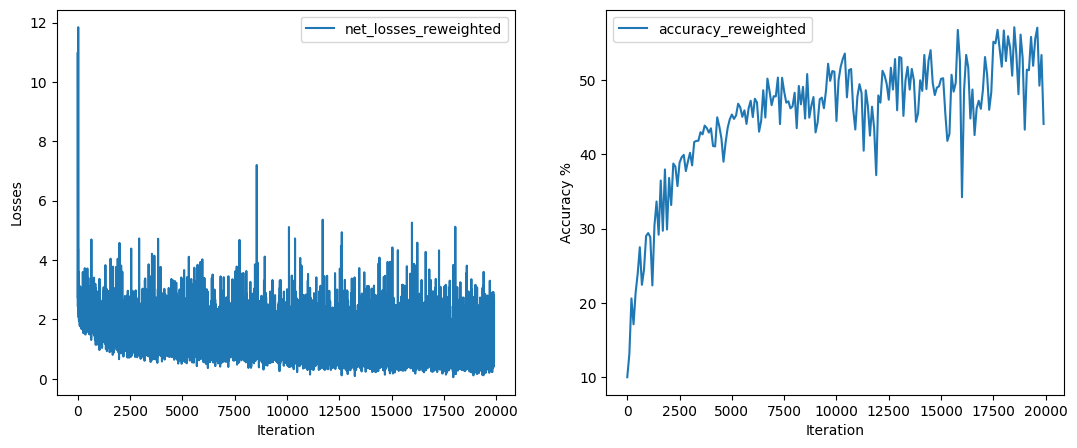

 95%|█████████▌| 1901/2000 [1:05:41<14:25,  8.74s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 1902/2000 [1:05:43<10:51,  6.65s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 1903/2000 [1:05:44<08:22,  5.18s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 1904/2000 [1:05:46<06:37,  4.14s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 1905/2000 [1:05:48<05:31,  3.49s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 1906/2000 [1:05:50<04:39,  2.97s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 1907/2000 [1:05:52<04:02,  2.61s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 1908/2000 [1:05:54<03:46,  2.46s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 1909/2000 [1:05:56<03:29,  2.31s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1910/2000 [1:05:57<03:12,  2.13s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1911/2000 [1:05:59<03:00,  2.02s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1912/2000 [1:06:01<02:50,  1.94s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1913/2000 [1:06:03<02:43,  1.88s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1914/2000 [1:06:04<02:37,  1.83s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1915/2000 [1:06:06<02:42,  1.92s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1916/2000 [1:06:09<02:47,  1.99s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1917/2000 [1:06:10<02:38,  1.91s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1918/2000 [1:06:12<02:32,  1.86s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1919/2000 [1:06:14<02:28,  1.83s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1920/2000 [1:06:16<02:24,  1.80s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1921/2000 [1:06:17<02:21,  1.79s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1922/2000 [1:06:19<02:18,  1.78s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1923/2000 [1:06:21<02:25,  1.89s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 1924/2000 [1:06:23<02:24,  1.90s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 1925/2000 [1:06:25<02:19,  1.85s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 1926/2000 [1:06:27<02:15,  1.83s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 1927/2000 [1:06:28<02:11,  1.80s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 1928/2000 [1:06:30<02:08,  1.79s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 1929/2000 [1:06:32<02:06,  1.78s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 1930/2000 [1:06:34<02:10,  1.87s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1931/2000 [1:06:36<02:14,  1.96s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1932/2000 [1:06:38<02:09,  1.90s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1933/2000 [1:06:40<02:04,  1.85s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1934/2000 [1:06:41<02:00,  1.82s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1935/2000 [1:06:43<01:57,  1.80s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1936/2000 [1:06:45<01:54,  1.79s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1937/2000 [1:06:47<01:53,  1.80s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1938/2000 [1:06:49<01:58,  1.91s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1939/2000 [1:06:51<01:55,  1.89s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1940/2000 [1:06:52<01:50,  1.84s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1941/2000 [1:06:54<01:47,  1.82s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1942/2000 [1:06:56<01:44,  1.80s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1943/2000 [1:06:58<01:41,  1.78s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1944/2000 [1:06:59<01:39,  1.77s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1945/2000 [1:07:02<01:44,  1.90s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1946/2000 [1:07:04<01:46,  1.98s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1947/2000 [1:07:06<01:41,  1.91s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1948/2000 [1:07:07<01:36,  1.86s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 1949/2000 [1:07:09<01:33,  1.83s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1950/2000 [1:07:11<01:30,  1.81s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1951/2000 [1:07:13<01:27,  1.79s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1952/2000 [1:07:15<01:28,  1.85s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1953/2000 [1:07:17<01:30,  1.93s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1954/2000 [1:07:18<01:26,  1.88s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1955/2000 [1:07:20<01:22,  1.84s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1956/2000 [1:07:22<01:19,  1.82s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1957/2000 [1:07:24<01:17,  1.81s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1958/2000 [1:07:25<01:15,  1.79s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1959/2000 [1:07:27<01:12,  1.77s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1960/2000 [1:07:29<01:15,  1.88s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1961/2000 [1:07:31<01:16,  1.96s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1962/2000 [1:07:33<01:12,  1.91s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1963/2000 [1:07:35<01:08,  1.86s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1964/2000 [1:07:37<01:05,  1.83s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1965/2000 [1:07:39<01:03,  1.81s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1966/2000 [1:07:40<01:00,  1.79s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1967/2000 [1:07:42<01:02,  1.91s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1968/2000 [1:07:45<01:02,  1.97s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1969/2000 [1:07:46<00:58,  1.90s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 1970/2000 [1:07:48<00:55,  1.85s/it]

| Wide-Resnet 28x10


 99%|█████████▊| 1971/2000 [1:07:50<00:52,  1.82s/it]

| Wide-Resnet 28x10


 99%|█████████▊| 1972/2000 [1:07:52<00:50,  1.80s/it]

| Wide-Resnet 28x10


 99%|█████████▊| 1973/2000 [1:07:53<00:48,  1.79s/it]

| Wide-Resnet 28x10


 99%|█████████▊| 1974/2000 [1:07:55<00:46,  1.77s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1975/2000 [1:07:57<00:47,  1.89s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1976/2000 [1:07:59<00:46,  1.92s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1977/2000 [1:08:01<00:43,  1.87s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1978/2000 [1:08:03<00:40,  1.85s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1979/2000 [1:08:05<00:38,  1.82s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1980/2000 [1:08:06<00:35,  1.79s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1981/2000 [1:08:08<00:33,  1.77s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1982/2000 [1:08:10<00:33,  1.87s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1983/2000 [1:08:12<00:33,  1.95s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1984/2000 [1:08:14<00:30,  1.88s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1985/2000 [1:08:16<00:27,  1.85s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1986/2000 [1:08:17<00:25,  1.82s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1987/2000 [1:08:19<00:23,  1.80s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1988/2000 [1:08:21<00:21,  1.78s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 1989/2000 [1:08:23<00:19,  1.77s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1990/2000 [1:08:25<00:18,  1.87s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1991/2000 [1:08:27<00:17,  1.91s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1992/2000 [1:08:29<00:14,  1.86s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1993/2000 [1:08:30<00:12,  1.83s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1994/2000 [1:08:32<00:10,  1.80s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1995/2000 [1:08:34<00:08,  1.79s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1996/2000 [1:08:36<00:07,  1.79s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1997/2000 [1:08:38<00:05,  1.90s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1998/2000 [1:08:40<00:03,  1.98s/it]

| Wide-Resnet 28x10


100%|█████████▉| 1999/2000 [1:08:42<00:01,  1.91s/it]

| Wide-Resnet 28x10


100%|██████████| 2000/2000 [1:08:43<00:00,  2.06s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-6d3822fa63ba>", line 1, in <cell line: 1>
    acc_log, net_losses = train_lre_cifar_reweight()
  File "<ipython-input-29-d7d8eef29783>", line 116, in train_lre_cifar_reweight
    torch.save(net.state_dict(), 'cifar_bkgnd_reweight.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: File cifar_bkgnd_reweight.pt cannot be opened.

During handling of the above exception, 

In [ ]:
acc_log, net_losses = train_lre_cifar_reweight()
with open('acc_log_cifar_bkgnd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_cifar_bkgnd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses, delimiter=',',fmt='%s', comments='')
  csvfile.close()

In [ ]:
iter_start = 20000
iter_end = 22000

In [ ]:
acc_log, net_losses = train_lre_cifar_reweight()
with open('acc_log_cifar_bkgnd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_cifar_bkgnd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses, delimiter=',',fmt='%s', comments='')
  csvfile.close()

| Wide-Resnet 28x10


  0%|          | 0/1000 [00:00<?, ?it/s]

| Wide-Resnet 28x10


  0%|          | 1/1000 [00:28<7:58:35, 28.74s/it]

| Wide-Resnet 28x10


  0%|          | 2/1000 [00:30<3:30:29, 12.65s/it]

| Wide-Resnet 28x10


  0%|          | 3/1000 [00:31<2:05:17,  7.54s/it]

| Wide-Resnet 28x10


  0%|          | 4/1000 [00:33<1:26:59,  5.24s/it]

| Wide-Resnet 28x10


  0%|          | 5/1000 [00:35<1:06:02,  3.98s/it]

| Wide-Resnet 28x10


  1%|          | 6/1000 [00:36<51:22,  3.10s/it]  

| Wide-Resnet 28x10


  1%|          | 7/1000 [00:37<42:09,  2.55s/it]

| Wide-Resnet 28x10


  1%|          | 8/1000 [00:39<36:03,  2.18s/it]

| Wide-Resnet 28x10


  1%|          | 9/1000 [00:40<31:53,  1.93s/it]

| Wide-Resnet 28x10


  1%|          | 10/1000 [00:42<29:10,  1.77s/it]

| Wide-Resnet 28x10


  1%|          | 11/1000 [00:43<27:16,  1.65s/it]

| Wide-Resnet 28x10


  1%|          | 12/1000 [00:44<25:49,  1.57s/it]

| Wide-Resnet 28x10


  1%|▏         | 13/1000 [00:46<26:24,  1.61s/it]

| Wide-Resnet 28x10


  1%|▏         | 14/1000 [00:48<26:56,  1.64s/it]

| Wide-Resnet 28x10


  2%|▏         | 15/1000 [00:49<26:20,  1.60s/it]

| Wide-Resnet 28x10


  2%|▏         | 16/1000 [00:51<25:20,  1.55s/it]

| Wide-Resnet 28x10


  2%|▏         | 17/1000 [00:52<24:34,  1.50s/it]

| Wide-Resnet 28x10


  2%|▏         | 18/1000 [00:53<23:56,  1.46s/it]

| Wide-Resnet 28x10


  2%|▏         | 19/1000 [00:55<23:39,  1.45s/it]

| Wide-Resnet 28x10


  2%|▏         | 20/1000 [00:56<23:23,  1.43s/it]

| Wide-Resnet 28x10


  2%|▏         | 21/1000 [00:58<23:06,  1.42s/it]

| Wide-Resnet 28x10


  2%|▏         | 22/1000 [00:59<22:58,  1.41s/it]

| Wide-Resnet 28x10


  2%|▏         | 23/1000 [01:01<24:23,  1.50s/it]

| Wide-Resnet 28x10


  2%|▏         | 24/1000 [01:02<25:25,  1.56s/it]

| Wide-Resnet 28x10


  2%|▎         | 25/1000 [01:04<24:27,  1.51s/it]

| Wide-Resnet 28x10


  3%|▎         | 26/1000 [01:05<23:51,  1.47s/it]

| Wide-Resnet 28x10


  3%|▎         | 27/1000 [01:07<23:26,  1.45s/it]

| Wide-Resnet 28x10


  3%|▎         | 28/1000 [01:08<23:16,  1.44s/it]

| Wide-Resnet 28x10


  3%|▎         | 29/1000 [01:09<23:07,  1.43s/it]

| Wide-Resnet 28x10


  3%|▎         | 30/1000 [01:11<22:51,  1.41s/it]

| Wide-Resnet 28x10


  3%|▎         | 31/1000 [01:12<22:45,  1.41s/it]

| Wide-Resnet 28x10


  3%|▎         | 32/1000 [01:14<24:20,  1.51s/it]

| Wide-Resnet 28x10


  3%|▎         | 33/1000 [01:16<25:22,  1.57s/it]

| Wide-Resnet 28x10


  3%|▎         | 34/1000 [01:17<24:30,  1.52s/it]

| Wide-Resnet 28x10


  4%|▎         | 35/1000 [01:18<23:58,  1.49s/it]

| Wide-Resnet 28x10


  4%|▎         | 36/1000 [01:20<23:32,  1.47s/it]

| Wide-Resnet 28x10


  4%|▎         | 37/1000 [01:21<23:08,  1.44s/it]

| Wide-Resnet 28x10


  4%|▍         | 38/1000 [01:23<22:54,  1.43s/it]

| Wide-Resnet 28x10


  4%|▍         | 39/1000 [01:24<22:43,  1.42s/it]

| Wide-Resnet 28x10


  4%|▍         | 40/1000 [01:25<22:34,  1.41s/it]

| Wide-Resnet 28x10


  4%|▍         | 41/1000 [01:27<23:56,  1.50s/it]

| Wide-Resnet 28x10


  4%|▍         | 42/1000 [01:29<24:57,  1.56s/it]

| Wide-Resnet 28x10


  4%|▍         | 43/1000 [01:30<24:32,  1.54s/it]

| Wide-Resnet 28x10


  4%|▍         | 44/1000 [01:32<23:51,  1.50s/it]

| Wide-Resnet 28x10


  4%|▍         | 45/1000 [01:33<23:21,  1.47s/it]

| Wide-Resnet 28x10


  5%|▍         | 46/1000 [01:35<22:58,  1.45s/it]

| Wide-Resnet 28x10


  5%|▍         | 47/1000 [01:36<22:41,  1.43s/it]

| Wide-Resnet 28x10


  5%|▍         | 48/1000 [01:37<22:32,  1.42s/it]

| Wide-Resnet 28x10


  5%|▍         | 49/1000 [01:39<22:35,  1.43s/it]

| Wide-Resnet 28x10


  5%|▌         | 50/1000 [01:40<22:49,  1.44s/it]

| Wide-Resnet 28x10


  5%|▌         | 51/1000 [01:42<24:10,  1.53s/it]

| Wide-Resnet 28x10


  5%|▌         | 52/1000 [01:44<25:07,  1.59s/it]

| Wide-Resnet 28x10


  5%|▌         | 53/1000 [01:45<24:15,  1.54s/it]

| Wide-Resnet 28x10


  5%|▌         | 54/1000 [01:47<23:37,  1.50s/it]

| Wide-Resnet 28x10


  6%|▌         | 55/1000 [01:48<23:08,  1.47s/it]

| Wide-Resnet 28x10


  6%|▌         | 56/1000 [01:49<22:50,  1.45s/it]

| Wide-Resnet 28x10


  6%|▌         | 57/1000 [01:51<22:33,  1.44s/it]

| Wide-Resnet 28x10


  6%|▌         | 58/1000 [01:52<22:32,  1.44s/it]

| Wide-Resnet 28x10


  6%|▌         | 59/1000 [01:54<22:30,  1.44s/it]

| Wide-Resnet 28x10


  6%|▌         | 60/1000 [01:55<23:49,  1.52s/it]

| Wide-Resnet 28x10


  6%|▌         | 61/1000 [01:57<24:38,  1.57s/it]

| Wide-Resnet 28x10


  6%|▌         | 62/1000 [01:58<23:41,  1.52s/it]

| Wide-Resnet 28x10


  6%|▋         | 63/1000 [02:00<23:08,  1.48s/it]

| Wide-Resnet 28x10


  6%|▋         | 64/1000 [02:01<22:40,  1.45s/it]

| Wide-Resnet 28x10


  6%|▋         | 65/1000 [02:03<22:21,  1.43s/it]

| Wide-Resnet 28x10


  7%|▋         | 66/1000 [02:04<22:12,  1.43s/it]

| Wide-Resnet 28x10


  7%|▋         | 67/1000 [02:05<22:00,  1.42s/it]

| Wide-Resnet 28x10


  7%|▋         | 68/1000 [02:07<21:55,  1.41s/it]

| Wide-Resnet 28x10


  7%|▋         | 69/1000 [02:09<23:23,  1.51s/it]

| Wide-Resnet 28x10


  7%|▋         | 70/1000 [02:10<24:28,  1.58s/it]

| Wide-Resnet 28x10


  7%|▋         | 71/1000 [02:12<23:32,  1.52s/it]

| Wide-Resnet 28x10


  7%|▋         | 72/1000 [02:13<23:03,  1.49s/it]

| Wide-Resnet 28x10


  7%|▋         | 73/1000 [02:14<22:35,  1.46s/it]

| Wide-Resnet 28x10


  7%|▋         | 74/1000 [02:16<22:14,  1.44s/it]

| Wide-Resnet 28x10


  8%|▊         | 75/1000 [02:17<22:00,  1.43s/it]

| Wide-Resnet 28x10


  8%|▊         | 76/1000 [02:19<21:47,  1.42s/it]

| Wide-Resnet 28x10


  8%|▊         | 77/1000 [02:20<21:43,  1.41s/it]

| Wide-Resnet 28x10


  8%|▊         | 78/1000 [02:22<22:55,  1.49s/it]

| Wide-Resnet 28x10


  8%|▊         | 79/1000 [02:23<24:02,  1.57s/it]

| Wide-Resnet 28x10


  8%|▊         | 80/1000 [02:25<23:51,  1.56s/it]

| Wide-Resnet 28x10


  8%|▊         | 81/1000 [02:26<23:13,  1.52s/it]

| Wide-Resnet 28x10


  8%|▊         | 82/1000 [02:28<22:44,  1.49s/it]

| Wide-Resnet 28x10


  8%|▊         | 83/1000 [02:29<22:13,  1.45s/it]

| Wide-Resnet 28x10


  8%|▊         | 84/1000 [02:31<22:04,  1.45s/it]

| Wide-Resnet 28x10


  8%|▊         | 85/1000 [02:32<21:47,  1.43s/it]

| Wide-Resnet 28x10


  9%|▊         | 86/1000 [02:33<21:37,  1.42s/it]

| Wide-Resnet 28x10


  9%|▊         | 87/1000 [02:35<21:41,  1.43s/it]

| Wide-Resnet 28x10


  9%|▉         | 88/1000 [02:37<22:59,  1.51s/it]

| Wide-Resnet 28x10


  9%|▉         | 89/1000 [02:38<23:58,  1.58s/it]

| Wide-Resnet 28x10


  9%|▉         | 90/1000 [02:40<23:06,  1.52s/it]

| Wide-Resnet 28x10


  9%|▉         | 91/1000 [02:41<22:35,  1.49s/it]

| Wide-Resnet 28x10


  9%|▉         | 92/1000 [02:43<22:07,  1.46s/it]

| Wide-Resnet 28x10


  9%|▉         | 93/1000 [02:44<21:53,  1.45s/it]

| Wide-Resnet 28x10


  9%|▉         | 94/1000 [02:45<21:36,  1.43s/it]

| Wide-Resnet 28x10


 10%|▉         | 95/1000 [02:47<21:24,  1.42s/it]

| Wide-Resnet 28x10


 10%|▉         | 96/1000 [02:48<21:22,  1.42s/it]

| Wide-Resnet 28x10


 10%|▉         | 97/1000 [02:50<22:47,  1.51s/it]

| Wide-Resnet 28x10


 10%|▉         | 98/1000 [02:52<23:38,  1.57s/it]

| Wide-Resnet 28x10


 10%|▉         | 99/1000 [02:53<23:06,  1.54s/it]

| Wide-Resnet 28x10


 10%|█         | 100/1000 [02:54<22:36,  1.51s/it]

| Wide-Resnet 28x10


 10%|█         | 101/1000 [02:56<22:03,  1.47s/it]

| Wide-Resnet 28x10


 10%|█         | 102/1000 [02:57<21:47,  1.46s/it]

| Wide-Resnet 28x10


 10%|█         | 103/1000 [02:59<21:29,  1.44s/it]

| Wide-Resnet 28x10


 10%|█         | 104/1000 [03:00<21:15,  1.42s/it]

| Wide-Resnet 28x10


 10%|█         | 105/1000 [03:01<21:11,  1.42s/it]

| Wide-Resnet 28x10


 11%|█         | 106/1000 [03:03<22:34,  1.51s/it]

| Wide-Resnet 28x10


 11%|█         | 107/1000 [03:05<23:42,  1.59s/it]

| Wide-Resnet 28x10


 11%|█         | 108/1000 [03:06<22:45,  1.53s/it]

| Wide-Resnet 28x10


 11%|█         | 109/1000 [03:08<22:09,  1.49s/it]

| Wide-Resnet 28x10


 11%|█         | 110/1000 [03:09<21:42,  1.46s/it]

| Wide-Resnet 28x10


 11%|█         | 111/1000 [03:11<21:28,  1.45s/it]

| Wide-Resnet 28x10


 11%|█         | 112/1000 [03:12<21:18,  1.44s/it]

| Wide-Resnet 28x10


 11%|█▏        | 113/1000 [03:13<21:09,  1.43s/it]

| Wide-Resnet 28x10


 11%|█▏        | 114/1000 [03:15<21:08,  1.43s/it]

| Wide-Resnet 28x10


 12%|█▏        | 115/1000 [03:17<22:23,  1.52s/it]

| Wide-Resnet 28x10


 12%|█▏        | 116/1000 [03:18<23:11,  1.57s/it]

| Wide-Resnet 28x10


 12%|█▏        | 117/1000 [03:20<22:47,  1.55s/it]

| Wide-Resnet 28x10


 12%|█▏        | 118/1000 [03:21<22:13,  1.51s/it]

| Wide-Resnet 28x10


 12%|█▏        | 119/1000 [03:23<21:45,  1.48s/it]

| Wide-Resnet 28x10


 12%|█▏        | 120/1000 [03:24<21:25,  1.46s/it]

| Wide-Resnet 28x10


 12%|█▏        | 121/1000 [03:25<21:08,  1.44s/it]

| Wide-Resnet 28x10


 12%|█▏        | 122/1000 [03:27<20:59,  1.43s/it]

| Wide-Resnet 28x10


 12%|█▏        | 123/1000 [03:28<20:48,  1.42s/it]

| Wide-Resnet 28x10


 12%|█▏        | 124/1000 [03:30<21:19,  1.46s/it]

| Wide-Resnet 28x10


 12%|█▎        | 125/1000 [03:32<22:32,  1.55s/it]

| Wide-Resnet 28x10


 13%|█▎        | 126/1000 [03:33<23:04,  1.58s/it]

| Wide-Resnet 28x10


 13%|█▎        | 127/1000 [03:35<22:22,  1.54s/it]

| Wide-Resnet 28x10


 13%|█▎        | 128/1000 [03:36<21:42,  1.49s/it]

| Wide-Resnet 28x10


 13%|█▎        | 129/1000 [03:37<21:13,  1.46s/it]

| Wide-Resnet 28x10


 13%|█▎        | 130/1000 [03:39<20:55,  1.44s/it]

| Wide-Resnet 28x10


 13%|█▎        | 131/1000 [03:40<20:38,  1.43s/it]

| Wide-Resnet 28x10


 13%|█▎        | 132/1000 [03:42<20:31,  1.42s/it]

| Wide-Resnet 28x10


 13%|█▎        | 133/1000 [03:43<20:21,  1.41s/it]

| Wide-Resnet 28x10


 13%|█▎        | 134/1000 [03:45<21:45,  1.51s/it]

| Wide-Resnet 28x10


 14%|█▎        | 135/1000 [03:46<22:29,  1.56s/it]

| Wide-Resnet 28x10


 14%|█▎        | 136/1000 [03:48<21:43,  1.51s/it]

| Wide-Resnet 28x10


 14%|█▎        | 137/1000 [03:49<21:13,  1.48s/it]

| Wide-Resnet 28x10


 14%|█▍        | 138/1000 [03:51<20:51,  1.45s/it]

| Wide-Resnet 28x10


 14%|█▍        | 139/1000 [03:52<20:39,  1.44s/it]

| Wide-Resnet 28x10


 14%|█▍        | 140/1000 [03:53<20:41,  1.44s/it]

| Wide-Resnet 28x10


 14%|█▍        | 141/1000 [03:55<20:35,  1.44s/it]

| Wide-Resnet 28x10


 14%|█▍        | 142/1000 [03:56<20:24,  1.43s/it]

| Wide-Resnet 28x10


 14%|█▍        | 143/1000 [03:58<21:39,  1.52s/it]

| Wide-Resnet 28x10


 14%|█▍        | 144/1000 [04:00<22:31,  1.58s/it]

| Wide-Resnet 28x10


 14%|█▍        | 145/1000 [04:01<21:42,  1.52s/it]

| Wide-Resnet 28x10


 15%|█▍        | 146/1000 [04:03<21:10,  1.49s/it]

| Wide-Resnet 28x10


 15%|█▍        | 147/1000 [04:04<20:47,  1.46s/it]

| Wide-Resnet 28x10


 15%|█▍        | 148/1000 [04:05<20:27,  1.44s/it]

| Wide-Resnet 28x10


 15%|█▍        | 149/1000 [04:07<20:17,  1.43s/it]

| Wide-Resnet 28x10


 15%|█▌        | 150/1000 [04:08<20:12,  1.43s/it]

| Wide-Resnet 28x10


 15%|█▌        | 151/1000 [04:10<20:07,  1.42s/it]

| Wide-Resnet 28x10


 15%|█▌        | 152/1000 [04:11<21:15,  1.50s/it]

| Wide-Resnet 28x10


 15%|█▌        | 153/1000 [04:13<22:52,  1.62s/it]

| Wide-Resnet 28x10


 15%|█▌        | 154/1000 [04:15<21:56,  1.56s/it]

| Wide-Resnet 28x10


 16%|█▌        | 155/1000 [04:16<21:20,  1.52s/it]

| Wide-Resnet 28x10


 16%|█▌        | 156/1000 [04:17<20:44,  1.47s/it]

| Wide-Resnet 28x10


 16%|█▌        | 157/1000 [04:19<20:27,  1.46s/it]

| Wide-Resnet 28x10


 16%|█▌        | 158/1000 [04:20<20:15,  1.44s/it]

| Wide-Resnet 28x10


 16%|█▌        | 159/1000 [04:22<20:02,  1.43s/it]

| Wide-Resnet 28x10


 16%|█▌        | 160/1000 [04:23<19:51,  1.42s/it]

| Wide-Resnet 28x10


 16%|█▌        | 161/1000 [04:25<20:33,  1.47s/it]

| Wide-Resnet 28x10


 16%|█▌        | 162/1000 [04:26<21:37,  1.55s/it]

| Wide-Resnet 28x10


 16%|█▋        | 163/1000 [04:28<22:14,  1.59s/it]

| Wide-Resnet 28x10


 16%|█▋        | 164/1000 [04:29<21:26,  1.54s/it]

| Wide-Resnet 28x10


 16%|█▋        | 165/1000 [04:31<20:48,  1.50s/it]

| Wide-Resnet 28x10


 17%|█▋        | 166/1000 [04:32<20:21,  1.46s/it]

| Wide-Resnet 28x10


 17%|█▋        | 167/1000 [04:34<20:08,  1.45s/it]

| Wide-Resnet 28x10


 17%|█▋        | 168/1000 [04:35<19:58,  1.44s/it]

| Wide-Resnet 28x10


 17%|█▋        | 169/1000 [04:36<19:49,  1.43s/it]

| Wide-Resnet 28x10


 17%|█▋        | 170/1000 [04:38<19:37,  1.42s/it]

| Wide-Resnet 28x10


 17%|█▋        | 171/1000 [04:40<20:58,  1.52s/it]

| Wide-Resnet 28x10


 17%|█▋        | 172/1000 [04:41<21:42,  1.57s/it]

| Wide-Resnet 28x10


 17%|█▋        | 173/1000 [04:43<20:54,  1.52s/it]

| Wide-Resnet 28x10


 17%|█▋        | 174/1000 [04:44<20:25,  1.48s/it]

| Wide-Resnet 28x10


 18%|█▊        | 175/1000 [04:45<20:07,  1.46s/it]

| Wide-Resnet 28x10


 18%|█▊        | 176/1000 [04:47<19:54,  1.45s/it]

| Wide-Resnet 28x10


 18%|█▊        | 177/1000 [04:48<19:39,  1.43s/it]

| Wide-Resnet 28x10


 18%|█▊        | 178/1000 [04:50<19:38,  1.43s/it]

| Wide-Resnet 28x10


 18%|█▊        | 179/1000 [04:51<19:27,  1.42s/it]

| Wide-Resnet 28x10


 18%|█▊        | 180/1000 [04:53<20:57,  1.53s/it]

| Wide-Resnet 28x10


 18%|█▊        | 181/1000 [04:55<21:45,  1.59s/it]

| Wide-Resnet 28x10


 18%|█▊        | 182/1000 [04:56<20:57,  1.54s/it]

| Wide-Resnet 28x10


 18%|█▊        | 183/1000 [04:57<20:20,  1.49s/it]

| Wide-Resnet 28x10


 18%|█▊        | 184/1000 [04:59<20:01,  1.47s/it]

| Wide-Resnet 28x10


 18%|█▊        | 185/1000 [05:00<19:41,  1.45s/it]

| Wide-Resnet 28x10


 19%|█▊        | 186/1000 [05:02<19:30,  1.44s/it]

| Wide-Resnet 28x10


 19%|█▊        | 187/1000 [05:03<19:19,  1.43s/it]

| Wide-Resnet 28x10


 19%|█▉        | 188/1000 [05:04<19:10,  1.42s/it]

| Wide-Resnet 28x10


 19%|█▉        | 189/1000 [05:06<20:25,  1.51s/it]

| Wide-Resnet 28x10


 19%|█▉        | 190/1000 [05:08<21:18,  1.58s/it]

| Wide-Resnet 28x10


 19%|█▉        | 191/1000 [05:09<21:00,  1.56s/it]

| Wide-Resnet 28x10


 19%|█▉        | 192/1000 [05:11<20:22,  1.51s/it]

| Wide-Resnet 28x10


 19%|█▉        | 193/1000 [05:12<19:53,  1.48s/it]

| Wide-Resnet 28x10


 19%|█▉        | 194/1000 [05:14<19:31,  1.45s/it]

| Wide-Resnet 28x10


 20%|█▉        | 195/1000 [05:15<19:15,  1.44s/it]

| Wide-Resnet 28x10


 20%|█▉        | 196/1000 [05:16<19:05,  1.42s/it]

| Wide-Resnet 28x10


 20%|█▉        | 197/1000 [05:18<18:58,  1.42s/it]

| Wide-Resnet 28x10


 20%|█▉        | 198/1000 [05:19<19:16,  1.44s/it]

| Wide-Resnet 28x10


 20%|█▉        | 199/1000 [05:21<20:32,  1.54s/it]

| Wide-Resnet 28x10


 20%|██        | 200/1000 [05:23<21:04,  1.58s/it]

| Wide-Resnet 28x10


 20%|██        | 201/1000 [05:52<2:09:45,  9.74s/it]

| Wide-Resnet 28x10


 20%|██        | 202/1000 [05:53<1:36:14,  7.24s/it]

| Wide-Resnet 28x10


 20%|██        | 203/1000 [05:54<1:12:57,  5.49s/it]

| Wide-Resnet 28x10


 20%|██        | 204/1000 [05:56<56:31,  4.26s/it]  

| Wide-Resnet 28x10


 20%|██        | 205/1000 [05:57<45:03,  3.40s/it]

| Wide-Resnet 28x10


 21%|██        | 206/1000 [05:59<37:08,  2.81s/it]

| Wide-Resnet 28x10


 21%|██        | 207/1000 [06:00<31:34,  2.39s/it]

| Wide-Resnet 28x10


 21%|██        | 208/1000 [06:02<28:55,  2.19s/it]

| Wide-Resnet 28x10


 21%|██        | 209/1000 [06:03<27:02,  2.05s/it]

| Wide-Resnet 28x10


 21%|██        | 210/1000 [06:05<24:33,  1.86s/it]

| Wide-Resnet 28x10


 21%|██        | 211/1000 [06:06<22:38,  1.72s/it]

| Wide-Resnet 28x10


 21%|██        | 212/1000 [06:08<21:14,  1.62s/it]

| Wide-Resnet 28x10


 21%|██▏       | 213/1000 [06:09<20:21,  1.55s/it]

| Wide-Resnet 28x10


 21%|██▏       | 214/1000 [06:10<19:43,  1.51s/it]

| Wide-Resnet 28x10


 22%|██▏       | 215/1000 [06:12<19:14,  1.47s/it]

| Wide-Resnet 28x10


 22%|██▏       | 216/1000 [06:13<18:50,  1.44s/it]

| Wide-Resnet 28x10


 22%|██▏       | 217/1000 [06:15<19:59,  1.53s/it]

| Wide-Resnet 28x10


 22%|██▏       | 218/1000 [06:17<20:38,  1.58s/it]

| Wide-Resnet 28x10


 22%|██▏       | 219/1000 [06:18<19:59,  1.54s/it]

| Wide-Resnet 28x10


 22%|██▏       | 220/1000 [06:19<19:22,  1.49s/it]

| Wide-Resnet 28x10


 22%|██▏       | 221/1000 [06:21<19:00,  1.46s/it]

| Wide-Resnet 28x10


 22%|██▏       | 222/1000 [06:22<18:41,  1.44s/it]

| Wide-Resnet 28x10


 22%|██▏       | 223/1000 [06:24<18:26,  1.42s/it]

| Wide-Resnet 28x10


 22%|██▏       | 224/1000 [06:25<18:14,  1.41s/it]

| Wide-Resnet 28x10


 22%|██▎       | 225/1000 [06:26<18:06,  1.40s/it]

| Wide-Resnet 28x10


 23%|██▎       | 226/1000 [06:28<18:57,  1.47s/it]

| Wide-Resnet 28x10


 23%|██▎       | 227/1000 [06:30<20:11,  1.57s/it]

| Wide-Resnet 28x10


 23%|██▎       | 228/1000 [06:31<20:17,  1.58s/it]

| Wide-Resnet 28x10


 23%|██▎       | 229/1000 [06:33<19:33,  1.52s/it]

| Wide-Resnet 28x10


 23%|██▎       | 230/1000 [06:34<18:59,  1.48s/it]

| Wide-Resnet 28x10


 23%|██▎       | 231/1000 [06:36<18:38,  1.45s/it]

| Wide-Resnet 28x10


 23%|██▎       | 232/1000 [06:37<18:21,  1.43s/it]

| Wide-Resnet 28x10


 23%|██▎       | 233/1000 [06:38<18:08,  1.42s/it]

| Wide-Resnet 28x10


 23%|██▎       | 234/1000 [06:40<18:04,  1.42s/it]

| Wide-Resnet 28x10


 24%|██▎       | 235/1000 [06:41<18:02,  1.42s/it]

| Wide-Resnet 28x10


 24%|██▎       | 236/1000 [06:43<19:14,  1.51s/it]

| Wide-Resnet 28x10


 24%|██▎       | 237/1000 [06:45<20:04,  1.58s/it]

| Wide-Resnet 28x10


 24%|██▍       | 238/1000 [06:46<19:24,  1.53s/it]

| Wide-Resnet 28x10


 24%|██▍       | 239/1000 [06:47<18:52,  1.49s/it]

| Wide-Resnet 28x10


 24%|██▍       | 240/1000 [06:49<18:40,  1.47s/it]

| Wide-Resnet 28x10


 24%|██▍       | 241/1000 [06:50<18:20,  1.45s/it]

| Wide-Resnet 28x10


 24%|██▍       | 242/1000 [06:52<18:11,  1.44s/it]

| Wide-Resnet 28x10


 24%|██▍       | 243/1000 [06:53<18:04,  1.43s/it]

| Wide-Resnet 28x10


 24%|██▍       | 244/1000 [06:55<17:53,  1.42s/it]

| Wide-Resnet 28x10


 24%|██▍       | 245/1000 [06:56<18:58,  1.51s/it]

| Wide-Resnet 28x10


 25%|██▍       | 246/1000 [06:58<19:45,  1.57s/it]

| Wide-Resnet 28x10


 25%|██▍       | 247/1000 [06:59<19:14,  1.53s/it]

| Wide-Resnet 28x10


 25%|██▍       | 248/1000 [07:01<18:46,  1.50s/it]

| Wide-Resnet 28x10


 25%|██▍       | 249/1000 [07:02<18:26,  1.47s/it]

| Wide-Resnet 28x10


 25%|██▌       | 250/1000 [07:04<18:09,  1.45s/it]

| Wide-Resnet 28x10


 25%|██▌       | 251/1000 [07:05<17:58,  1.44s/it]

| Wide-Resnet 28x10


 25%|██▌       | 252/1000 [07:06<17:55,  1.44s/it]

| Wide-Resnet 28x10


 25%|██▌       | 253/1000 [07:08<17:48,  1.43s/it]

| Wide-Resnet 28x10


 25%|██▌       | 254/1000 [07:10<18:55,  1.52s/it]

| Wide-Resnet 28x10


 26%|██▌       | 255/1000 [07:11<19:41,  1.59s/it]

| Wide-Resnet 28x10


 26%|██▌       | 256/1000 [07:13<18:59,  1.53s/it]

| Wide-Resnet 28x10


 26%|██▌       | 257/1000 [07:14<18:27,  1.49s/it]

| Wide-Resnet 28x10


 26%|██▌       | 258/1000 [07:16<18:15,  1.48s/it]

| Wide-Resnet 28x10


 26%|██▌       | 259/1000 [07:17<17:53,  1.45s/it]

| Wide-Resnet 28x10


 26%|██▌       | 260/1000 [07:18<17:37,  1.43s/it]

| Wide-Resnet 28x10


 26%|██▌       | 261/1000 [07:20<17:41,  1.44s/it]

| Wide-Resnet 28x10


 26%|██▌       | 262/1000 [07:21<17:30,  1.42s/it]

| Wide-Resnet 28x10


 26%|██▋       | 263/1000 [07:23<18:33,  1.51s/it]

| Wide-Resnet 28x10


 26%|██▋       | 264/1000 [07:25<19:17,  1.57s/it]

| Wide-Resnet 28x10


 26%|██▋       | 265/1000 [07:26<19:07,  1.56s/it]

| Wide-Resnet 28x10


 27%|██▋       | 266/1000 [07:28<18:32,  1.52s/it]

| Wide-Resnet 28x10


 27%|██▋       | 267/1000 [07:29<18:09,  1.49s/it]

| Wide-Resnet 28x10


 27%|██▋       | 268/1000 [07:30<17:52,  1.46s/it]

| Wide-Resnet 28x10


 27%|██▋       | 269/1000 [07:32<17:39,  1.45s/it]

| Wide-Resnet 28x10


 27%|██▋       | 270/1000 [07:33<17:29,  1.44s/it]

| Wide-Resnet 28x10


 27%|██▋       | 271/1000 [07:35<17:23,  1.43s/it]

| Wide-Resnet 28x10


 27%|██▋       | 272/1000 [07:36<17:45,  1.46s/it]

| Wide-Resnet 28x10


 27%|██▋       | 273/1000 [07:38<18:32,  1.53s/it]

| Wide-Resnet 28x10


 27%|██▋       | 274/1000 [07:40<19:12,  1.59s/it]

| Wide-Resnet 28x10


 28%|██▊       | 275/1000 [07:41<18:26,  1.53s/it]

| Wide-Resnet 28x10


 28%|██▊       | 276/1000 [07:42<17:54,  1.48s/it]

| Wide-Resnet 28x10


 28%|██▊       | 277/1000 [07:44<17:32,  1.46s/it]

| Wide-Resnet 28x10


 28%|██▊       | 278/1000 [07:45<17:17,  1.44s/it]

| Wide-Resnet 28x10


 28%|██▊       | 279/1000 [07:47<17:07,  1.43s/it]

| Wide-Resnet 28x10


 28%|██▊       | 280/1000 [07:48<16:58,  1.42s/it]

| Wide-Resnet 28x10


 28%|██▊       | 281/1000 [07:49<16:52,  1.41s/it]

| Wide-Resnet 28x10


 28%|██▊       | 282/1000 [07:51<18:05,  1.51s/it]

| Wide-Resnet 28x10


 28%|██▊       | 283/1000 [07:53<18:47,  1.57s/it]

| Wide-Resnet 28x10


 28%|██▊       | 284/1000 [07:54<18:16,  1.53s/it]

| Wide-Resnet 28x10


 28%|██▊       | 285/1000 [07:56<17:46,  1.49s/it]

| Wide-Resnet 28x10


 29%|██▊       | 286/1000 [07:57<17:23,  1.46s/it]

| Wide-Resnet 28x10


 29%|██▊       | 287/1000 [07:58<17:09,  1.44s/it]

| Wide-Resnet 28x10


 29%|██▉       | 288/1000 [08:00<17:05,  1.44s/it]

| Wide-Resnet 28x10


 29%|██▉       | 289/1000 [08:01<16:54,  1.43s/it]

| Wide-Resnet 28x10


 29%|██▉       | 290/1000 [08:03<16:50,  1.42s/it]

| Wide-Resnet 28x10


 29%|██▉       | 291/1000 [08:04<17:54,  1.52s/it]

| Wide-Resnet 28x10


 29%|██▉       | 292/1000 [08:06<18:46,  1.59s/it]

| Wide-Resnet 28x10


 29%|██▉       | 293/1000 [08:08<18:02,  1.53s/it]

| Wide-Resnet 28x10


 29%|██▉       | 294/1000 [08:09<17:36,  1.50s/it]

| Wide-Resnet 28x10


 30%|██▉       | 295/1000 [08:10<17:22,  1.48s/it]

| Wide-Resnet 28x10


 30%|██▉       | 296/1000 [08:12<17:03,  1.45s/it]

| Wide-Resnet 28x10


 30%|██▉       | 297/1000 [08:13<16:54,  1.44s/it]

| Wide-Resnet 28x10


 30%|██▉       | 298/1000 [08:15<16:47,  1.43s/it]

| Wide-Resnet 28x10


 30%|██▉       | 299/1000 [08:16<16:36,  1.42s/it]

| Wide-Resnet 28x10


 30%|███       | 300/1000 [08:18<17:37,  1.51s/it]

| Wide-Resnet 28x10


 30%|███       | 301/1000 [08:20<18:27,  1.58s/it]

| Wide-Resnet 28x10


 30%|███       | 302/1000 [08:21<18:14,  1.57s/it]

| Wide-Resnet 28x10


 30%|███       | 303/1000 [08:22<17:38,  1.52s/it]

| Wide-Resnet 28x10


 30%|███       | 304/1000 [08:24<17:08,  1.48s/it]

| Wide-Resnet 28x10


 30%|███       | 305/1000 [08:25<16:50,  1.45s/it]

| Wide-Resnet 28x10


 31%|███       | 306/1000 [08:27<16:41,  1.44s/it]

| Wide-Resnet 28x10


 31%|███       | 307/1000 [08:28<16:30,  1.43s/it]

| Wide-Resnet 28x10


 31%|███       | 308/1000 [08:29<16:24,  1.42s/it]

| Wide-Resnet 28x10


 31%|███       | 309/1000 [08:31<16:42,  1.45s/it]

| Wide-Resnet 28x10


 31%|███       | 310/1000 [08:33<17:40,  1.54s/it]

| Wide-Resnet 28x10


 31%|███       | 311/1000 [08:34<18:15,  1.59s/it]

| Wide-Resnet 28x10


 31%|███       | 312/1000 [08:36<17:41,  1.54s/it]

| Wide-Resnet 28x10


 31%|███▏      | 313/1000 [08:37<17:09,  1.50s/it]

| Wide-Resnet 28x10


 31%|███▏      | 314/1000 [08:39<16:46,  1.47s/it]

| Wide-Resnet 28x10


 32%|███▏      | 315/1000 [08:40<16:33,  1.45s/it]

| Wide-Resnet 28x10


 32%|███▏      | 316/1000 [08:41<16:20,  1.43s/it]

| Wide-Resnet 28x10


 32%|███▏      | 317/1000 [08:43<16:15,  1.43s/it]

| Wide-Resnet 28x10


 32%|███▏      | 318/1000 [08:44<16:11,  1.42s/it]

| Wide-Resnet 28x10


 32%|███▏      | 319/1000 [08:46<17:15,  1.52s/it]

| Wide-Resnet 28x10


 32%|███▏      | 320/1000 [08:48<18:32,  1.64s/it]

| Wide-Resnet 28x10


 32%|███▏      | 321/1000 [08:49<17:43,  1.57s/it]

| Wide-Resnet 28x10


 32%|███▏      | 322/1000 [08:51<17:08,  1.52s/it]

| Wide-Resnet 28x10


 32%|███▏      | 323/1000 [08:52<16:46,  1.49s/it]

| Wide-Resnet 28x10


 32%|███▏      | 324/1000 [08:54<16:31,  1.47s/it]

| Wide-Resnet 28x10


 32%|███▎      | 325/1000 [08:55<16:34,  1.47s/it]

| Wide-Resnet 28x10


 33%|███▎      | 326/1000 [08:56<16:23,  1.46s/it]

| Wide-Resnet 28x10


 33%|███▎      | 327/1000 [08:58<16:13,  1.45s/it]

| Wide-Resnet 28x10


 33%|███▎      | 328/1000 [09:00<17:12,  1.54s/it]

| Wide-Resnet 28x10


 33%|███▎      | 329/1000 [09:01<17:45,  1.59s/it]

| Wide-Resnet 28x10


 33%|███▎      | 330/1000 [09:03<17:07,  1.53s/it]

| Wide-Resnet 28x10


 33%|███▎      | 331/1000 [09:04<16:40,  1.50s/it]

| Wide-Resnet 28x10


 33%|███▎      | 332/1000 [09:06<16:19,  1.47s/it]

| Wide-Resnet 28x10


 33%|███▎      | 333/1000 [09:07<16:03,  1.44s/it]

| Wide-Resnet 28x10


 33%|███▎      | 334/1000 [09:08<15:51,  1.43s/it]

| Wide-Resnet 28x10


 34%|███▎      | 335/1000 [09:10<15:47,  1.43s/it]

| Wide-Resnet 28x10


 34%|███▎      | 336/1000 [09:11<15:44,  1.42s/it]

| Wide-Resnet 28x10


 34%|███▎      | 337/1000 [09:13<16:45,  1.52s/it]

| Wide-Resnet 28x10


 34%|███▍      | 338/1000 [09:15<17:26,  1.58s/it]

| Wide-Resnet 28x10


 34%|███▍      | 339/1000 [09:16<16:49,  1.53s/it]

| Wide-Resnet 28x10


 34%|███▍      | 340/1000 [09:17<16:22,  1.49s/it]

| Wide-Resnet 28x10


 34%|███▍      | 341/1000 [09:19<16:04,  1.46s/it]

| Wide-Resnet 28x10


 34%|███▍      | 342/1000 [09:20<15:51,  1.45s/it]

| Wide-Resnet 28x10


 34%|███▍      | 343/1000 [09:22<15:44,  1.44s/it]

| Wide-Resnet 28x10


 34%|███▍      | 344/1000 [09:23<15:41,  1.44s/it]

| Wide-Resnet 28x10


 34%|███▍      | 345/1000 [09:25<15:35,  1.43s/it]

| Wide-Resnet 28x10


 35%|███▍      | 346/1000 [09:26<16:34,  1.52s/it]

| Wide-Resnet 28x10


 35%|███▍      | 347/1000 [09:28<17:14,  1.58s/it]

| Wide-Resnet 28x10


 35%|███▍      | 348/1000 [09:30<17:17,  1.59s/it]

| Wide-Resnet 28x10


 35%|███▍      | 349/1000 [09:31<16:39,  1.54s/it]

| Wide-Resnet 28x10


 35%|███▌      | 350/1000 [09:32<16:13,  1.50s/it]

| Wide-Resnet 28x10


 35%|███▌      | 351/1000 [09:34<15:55,  1.47s/it]

| Wide-Resnet 28x10


 35%|███▌      | 352/1000 [09:35<15:40,  1.45s/it]

| Wide-Resnet 28x10


 35%|███▌      | 353/1000 [09:37<15:31,  1.44s/it]

| Wide-Resnet 28x10


 35%|███▌      | 354/1000 [09:38<15:24,  1.43s/it]

| Wide-Resnet 28x10


 36%|███▌      | 355/1000 [09:40<15:31,  1.44s/it]

| Wide-Resnet 28x10


 36%|███▌      | 356/1000 [09:41<16:25,  1.53s/it]

| Wide-Resnet 28x10


 36%|███▌      | 357/1000 [09:43<16:59,  1.59s/it]

| Wide-Resnet 28x10


 36%|███▌      | 358/1000 [09:44<16:19,  1.53s/it]

| Wide-Resnet 28x10


 36%|███▌      | 359/1000 [09:46<15:54,  1.49s/it]

| Wide-Resnet 28x10


 36%|███▌      | 360/1000 [09:47<15:42,  1.47s/it]

| Wide-Resnet 28x10


 36%|███▌      | 361/1000 [09:49<15:30,  1.46s/it]

| Wide-Resnet 28x10


 36%|███▌      | 362/1000 [09:50<15:20,  1.44s/it]

| Wide-Resnet 28x10


 36%|███▋      | 363/1000 [09:51<15:14,  1.43s/it]

| Wide-Resnet 28x10


 36%|███▋      | 364/1000 [09:53<15:08,  1.43s/it]

| Wide-Resnet 28x10


 36%|███▋      | 365/1000 [09:55<16:05,  1.52s/it]

| Wide-Resnet 28x10


 37%|███▋      | 366/1000 [09:56<16:41,  1.58s/it]

| Wide-Resnet 28x10


 37%|███▋      | 367/1000 [09:58<16:10,  1.53s/it]

| Wide-Resnet 28x10


 37%|███▋      | 368/1000 [09:59<15:42,  1.49s/it]

| Wide-Resnet 28x10


 37%|███▋      | 369/1000 [10:01<15:28,  1.47s/it]

| Wide-Resnet 28x10


 37%|███▋      | 370/1000 [10:02<15:13,  1.45s/it]

| Wide-Resnet 28x10


 37%|███▋      | 371/1000 [10:03<15:03,  1.44s/it]

| Wide-Resnet 28x10


 37%|███▋      | 372/1000 [10:05<15:01,  1.44s/it]

| Wide-Resnet 28x10


 37%|███▋      | 373/1000 [10:06<14:50,  1.42s/it]

| Wide-Resnet 28x10


 37%|███▋      | 374/1000 [10:08<15:54,  1.52s/it]

| Wide-Resnet 28x10


 38%|███▊      | 375/1000 [10:10<16:35,  1.59s/it]

| Wide-Resnet 28x10


 38%|███▊      | 376/1000 [10:11<16:04,  1.55s/it]

| Wide-Resnet 28x10


 38%|███▊      | 377/1000 [10:13<15:38,  1.51s/it]

| Wide-Resnet 28x10


 38%|███▊      | 378/1000 [10:14<15:19,  1.48s/it]

| Wide-Resnet 28x10


 38%|███▊      | 379/1000 [10:15<15:02,  1.45s/it]

| Wide-Resnet 28x10


 38%|███▊      | 380/1000 [10:17<14:54,  1.44s/it]

| Wide-Resnet 28x10


 38%|███▊      | 381/1000 [10:18<14:45,  1.43s/it]

| Wide-Resnet 28x10


 38%|███▊      | 382/1000 [10:20<14:39,  1.42s/it]

| Wide-Resnet 28x10


 38%|███▊      | 383/1000 [10:21<15:14,  1.48s/it]

| Wide-Resnet 28x10


 38%|███▊      | 384/1000 [10:23<16:03,  1.56s/it]

| Wide-Resnet 28x10


 38%|███▊      | 385/1000 [10:25<16:07,  1.57s/it]

| Wide-Resnet 28x10


 39%|███▊      | 386/1000 [10:26<15:35,  1.52s/it]

| Wide-Resnet 28x10


 39%|███▊      | 387/1000 [10:27<15:14,  1.49s/it]

| Wide-Resnet 28x10


 39%|███▉      | 388/1000 [10:29<14:52,  1.46s/it]

| Wide-Resnet 28x10


 39%|███▉      | 389/1000 [10:30<14:43,  1.45s/it]

| Wide-Resnet 28x10


 39%|███▉      | 390/1000 [10:32<14:44,  1.45s/it]

| Wide-Resnet 28x10


 39%|███▉      | 391/1000 [10:33<14:35,  1.44s/it]

| Wide-Resnet 28x10


 39%|███▉      | 392/1000 [10:34<14:33,  1.44s/it]

| Wide-Resnet 28x10


 39%|███▉      | 393/1000 [10:36<15:20,  1.52s/it]

| Wide-Resnet 28x10


 39%|███▉      | 394/1000 [10:38<15:56,  1.58s/it]

| Wide-Resnet 28x10


 40%|███▉      | 395/1000 [10:39<15:23,  1.53s/it]

| Wide-Resnet 28x10


 40%|███▉      | 396/1000 [10:41<15:00,  1.49s/it]

| Wide-Resnet 28x10


 40%|███▉      | 397/1000 [10:42<14:42,  1.46s/it]

| Wide-Resnet 28x10


 40%|███▉      | 398/1000 [10:44<14:34,  1.45s/it]

| Wide-Resnet 28x10


 40%|███▉      | 399/1000 [10:45<14:25,  1.44s/it]

| Wide-Resnet 28x10


 40%|████      | 400/1000 [10:46<14:16,  1.43s/it]

| Wide-Resnet 28x10


 40%|████      | 401/1000 [11:15<1:36:33,  9.67s/it]

| Wide-Resnet 28x10


 40%|████      | 402/1000 [11:17<1:12:33,  7.28s/it]

| Wide-Resnet 28x10


 40%|████      | 403/1000 [11:19<55:56,  5.62s/it]  

| Wide-Resnet 28x10


 40%|████      | 404/1000 [11:20<43:12,  4.35s/it]

| Wide-Resnet 28x10


 40%|████      | 405/1000 [11:21<34:22,  3.47s/it]

| Wide-Resnet 28x10


 41%|████      | 406/1000 [11:23<28:13,  2.85s/it]

| Wide-Resnet 28x10


 41%|████      | 407/1000 [11:24<23:51,  2.41s/it]

| Wide-Resnet 28x10


 41%|████      | 408/1000 [11:26<20:50,  2.11s/it]

| Wide-Resnet 28x10


 41%|████      | 409/1000 [11:27<18:42,  1.90s/it]

| Wide-Resnet 28x10


 41%|████      | 410/1000 [11:29<17:11,  1.75s/it]

| Wide-Resnet 28x10


 41%|████      | 411/1000 [11:30<17:07,  1.74s/it]

| Wide-Resnet 28x10


 41%|████      | 412/1000 [11:32<17:03,  1.74s/it]

| Wide-Resnet 28x10


 41%|████▏     | 413/1000 [11:33<16:00,  1.64s/it]

| Wide-Resnet 28x10


 41%|████▏     | 414/1000 [11:35<15:14,  1.56s/it]

| Wide-Resnet 28x10


 42%|████▏     | 415/1000 [11:36<14:42,  1.51s/it]

| Wide-Resnet 28x10


 42%|████▏     | 416/1000 [11:38<14:20,  1.47s/it]

| Wide-Resnet 28x10


 42%|████▏     | 417/1000 [11:39<14:11,  1.46s/it]

| Wide-Resnet 28x10


 42%|████▏     | 418/1000 [11:40<14:01,  1.45s/it]

| Wide-Resnet 28x10


 42%|████▏     | 419/1000 [11:42<13:51,  1.43s/it]

| Wide-Resnet 28x10


 42%|████▏     | 420/1000 [11:43<14:28,  1.50s/it]

| Wide-Resnet 28x10


 42%|████▏     | 421/1000 [11:45<15:09,  1.57s/it]

| Wide-Resnet 28x10


 42%|████▏     | 422/1000 [11:47<15:03,  1.56s/it]

| Wide-Resnet 28x10


 42%|████▏     | 423/1000 [11:48<14:34,  1.52s/it]

| Wide-Resnet 28x10


 42%|████▏     | 424/1000 [11:50<14:11,  1.48s/it]

| Wide-Resnet 28x10


 42%|████▎     | 425/1000 [11:51<13:56,  1.46s/it]

| Wide-Resnet 28x10


 43%|████▎     | 426/1000 [11:52<13:45,  1.44s/it]

| Wide-Resnet 28x10


 43%|████▎     | 427/1000 [11:54<13:37,  1.43s/it]

| Wide-Resnet 28x10


 43%|████▎     | 428/1000 [11:55<13:50,  1.45s/it]

| Wide-Resnet 28x10


 43%|████▎     | 429/1000 [11:57<14:04,  1.48s/it]

| Wide-Resnet 28x10


 43%|████▎     | 430/1000 [11:58<14:47,  1.56s/it]

| Wide-Resnet 28x10


 43%|████▎     | 431/1000 [12:00<15:07,  1.60s/it]

| Wide-Resnet 28x10


 43%|████▎     | 432/1000 [12:02<14:33,  1.54s/it]

| Wide-Resnet 28x10


 43%|████▎     | 433/1000 [12:03<14:10,  1.50s/it]

| Wide-Resnet 28x10


 43%|████▎     | 434/1000 [12:04<13:49,  1.46s/it]

| Wide-Resnet 28x10


 44%|████▎     | 435/1000 [12:06<13:41,  1.45s/it]

| Wide-Resnet 28x10


 44%|████▎     | 436/1000 [12:07<13:31,  1.44s/it]

| Wide-Resnet 28x10


 44%|████▎     | 437/1000 [12:09<13:24,  1.43s/it]

| Wide-Resnet 28x10


 44%|████▍     | 438/1000 [12:10<13:17,  1.42s/it]

| Wide-Resnet 28x10


 44%|████▍     | 439/1000 [12:12<14:05,  1.51s/it]

| Wide-Resnet 28x10


 44%|████▍     | 440/1000 [12:14<14:49,  1.59s/it]

| Wide-Resnet 28x10


 44%|████▍     | 441/1000 [12:15<14:18,  1.54s/it]

| Wide-Resnet 28x10


 44%|████▍     | 442/1000 [12:16<13:56,  1.50s/it]

| Wide-Resnet 28x10


 44%|████▍     | 443/1000 [12:18<13:39,  1.47s/it]

| Wide-Resnet 28x10


 44%|████▍     | 444/1000 [12:19<13:27,  1.45s/it]

| Wide-Resnet 28x10


 44%|████▍     | 445/1000 [12:21<13:17,  1.44s/it]

| Wide-Resnet 28x10


 45%|████▍     | 446/1000 [12:22<13:10,  1.43s/it]

| Wide-Resnet 28x10


 45%|████▍     | 447/1000 [12:23<13:04,  1.42s/it]

| Wide-Resnet 28x10


 45%|████▍     | 448/1000 [12:25<13:58,  1.52s/it]

| Wide-Resnet 28x10


 45%|████▍     | 449/1000 [12:27<14:33,  1.58s/it]

| Wide-Resnet 28x10


 45%|████▌     | 450/1000 [12:28<14:03,  1.53s/it]

| Wide-Resnet 28x10


 45%|████▌     | 451/1000 [12:30<13:43,  1.50s/it]

| Wide-Resnet 28x10


 45%|████▌     | 452/1000 [12:31<13:27,  1.47s/it]

| Wide-Resnet 28x10


 45%|████▌     | 453/1000 [12:32<13:12,  1.45s/it]

| Wide-Resnet 28x10


 45%|████▌     | 454/1000 [12:34<13:03,  1.43s/it]

| Wide-Resnet 28x10


 46%|████▌     | 455/1000 [12:35<12:55,  1.42s/it]

| Wide-Resnet 28x10


 46%|████▌     | 456/1000 [12:37<12:53,  1.42s/it]

| Wide-Resnet 28x10


 46%|████▌     | 457/1000 [12:38<13:42,  1.52s/it]

| Wide-Resnet 28x10


 46%|████▌     | 458/1000 [12:40<14:20,  1.59s/it]

| Wide-Resnet 28x10


 46%|████▌     | 459/1000 [12:42<14:04,  1.56s/it]

| Wide-Resnet 28x10


 46%|████▌     | 460/1000 [12:43<13:37,  1.51s/it]

| Wide-Resnet 28x10


 46%|████▌     | 461/1000 [12:44<13:14,  1.47s/it]

| Wide-Resnet 28x10


 46%|████▌     | 462/1000 [12:46<13:07,  1.46s/it]

| Wide-Resnet 28x10


 46%|████▋     | 463/1000 [12:47<12:54,  1.44s/it]

| Wide-Resnet 28x10


 46%|████▋     | 464/1000 [12:49<12:51,  1.44s/it]

| Wide-Resnet 28x10


 46%|████▋     | 465/1000 [12:50<12:46,  1.43s/it]

| Wide-Resnet 28x10


 47%|████▋     | 466/1000 [12:52<13:09,  1.48s/it]

| Wide-Resnet 28x10


 47%|████▋     | 467/1000 [12:53<13:53,  1.56s/it]

| Wide-Resnet 28x10


 47%|████▋     | 468/1000 [12:55<14:06,  1.59s/it]

| Wide-Resnet 28x10


 47%|████▋     | 469/1000 [12:57<13:35,  1.54s/it]

| Wide-Resnet 28x10


 47%|████▋     | 470/1000 [12:58<13:14,  1.50s/it]

| Wide-Resnet 28x10


 47%|████▋     | 471/1000 [12:59<12:57,  1.47s/it]

| Wide-Resnet 28x10


 47%|████▋     | 472/1000 [13:01<12:47,  1.45s/it]

| Wide-Resnet 28x10


 47%|████▋     | 473/1000 [13:02<12:39,  1.44s/it]

| Wide-Resnet 28x10


 47%|████▋     | 474/1000 [13:04<12:34,  1.43s/it]

| Wide-Resnet 28x10


 48%|████▊     | 475/1000 [13:05<12:33,  1.44s/it]

| Wide-Resnet 28x10


 48%|████▊     | 476/1000 [13:07<13:18,  1.52s/it]

| Wide-Resnet 28x10


 48%|████▊     | 477/1000 [13:09<13:56,  1.60s/it]

| Wide-Resnet 28x10


 48%|████▊     | 478/1000 [13:10<13:28,  1.55s/it]

| Wide-Resnet 28x10


 48%|████▊     | 479/1000 [13:11<13:07,  1.51s/it]

| Wide-Resnet 28x10


 48%|████▊     | 480/1000 [13:13<12:52,  1.49s/it]

| Wide-Resnet 28x10


 48%|████▊     | 481/1000 [13:14<13:06,  1.52s/it]

| Wide-Resnet 28x10


 48%|████▊     | 482/1000 [13:16<12:48,  1.48s/it]

| Wide-Resnet 28x10


 48%|████▊     | 483/1000 [13:17<12:31,  1.45s/it]

| Wide-Resnet 28x10


 48%|████▊     | 484/1000 [13:19<12:26,  1.45s/it]

| Wide-Resnet 28x10


 48%|████▊     | 485/1000 [13:20<13:11,  1.54s/it]

| Wide-Resnet 28x10


 49%|████▊     | 486/1000 [13:22<13:42,  1.60s/it]

| Wide-Resnet 28x10


 49%|████▊     | 487/1000 [13:24<13:12,  1.54s/it]

| Wide-Resnet 28x10


 49%|████▉     | 488/1000 [13:25<12:50,  1.51s/it]

| Wide-Resnet 28x10


 49%|████▉     | 489/1000 [13:26<12:32,  1.47s/it]

| Wide-Resnet 28x10


 49%|████▉     | 490/1000 [13:28<12:18,  1.45s/it]

| Wide-Resnet 28x10


 49%|████▉     | 491/1000 [13:29<12:12,  1.44s/it]

| Wide-Resnet 28x10


 49%|████▉     | 492/1000 [13:31<12:05,  1.43s/it]

| Wide-Resnet 28x10


 49%|████▉     | 493/1000 [13:32<12:00,  1.42s/it]

| Wide-Resnet 28x10


 49%|████▉     | 494/1000 [13:34<12:43,  1.51s/it]

| Wide-Resnet 28x10


 50%|████▉     | 495/1000 [13:35<13:19,  1.58s/it]

| Wide-Resnet 28x10


 50%|████▉     | 496/1000 [13:37<12:48,  1.52s/it]

| Wide-Resnet 28x10


 50%|████▉     | 497/1000 [13:38<12:29,  1.49s/it]

| Wide-Resnet 28x10


 50%|████▉     | 498/1000 [13:40<12:19,  1.47s/it]

| Wide-Resnet 28x10


 50%|████▉     | 499/1000 [13:41<12:06,  1.45s/it]

| Wide-Resnet 28x10


 50%|█████     | 500/1000 [13:43<12:00,  1.44s/it]

| Wide-Resnet 28x10


 50%|█████     | 501/1000 [13:44<11:57,  1.44s/it]

| Wide-Resnet 28x10


 50%|█████     | 502/1000 [13:45<11:49,  1.43s/it]

| Wide-Resnet 28x10


 50%|█████     | 503/1000 [13:47<12:37,  1.52s/it]

| Wide-Resnet 28x10


 50%|█████     | 504/1000 [13:49<13:08,  1.59s/it]

| Wide-Resnet 28x10


 50%|█████     | 505/1000 [13:50<12:39,  1.53s/it]

| Wide-Resnet 28x10


 51%|█████     | 506/1000 [13:52<12:18,  1.49s/it]

| Wide-Resnet 28x10


 51%|█████     | 507/1000 [13:53<12:07,  1.48s/it]

| Wide-Resnet 28x10


 51%|█████     | 508/1000 [13:55<12:00,  1.46s/it]

| Wide-Resnet 28x10


 51%|█████     | 509/1000 [13:56<11:48,  1.44s/it]

| Wide-Resnet 28x10


 51%|█████     | 510/1000 [13:57<11:39,  1.43s/it]

| Wide-Resnet 28x10


 51%|█████     | 511/1000 [13:59<11:37,  1.43s/it]

| Wide-Resnet 28x10


 51%|█████     | 512/1000 [14:00<12:20,  1.52s/it]

| Wide-Resnet 28x10


 51%|█████▏    | 513/1000 [14:02<13:01,  1.60s/it]

| Wide-Resnet 28x10


 51%|█████▏    | 514/1000 [14:04<12:59,  1.60s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 515/1000 [14:05<12:31,  1.55s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 516/1000 [14:07<12:07,  1.50s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 517/1000 [14:08<11:51,  1.47s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 518/1000 [14:09<11:41,  1.46s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 519/1000 [14:11<11:31,  1.44s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 520/1000 [14:12<11:25,  1.43s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 521/1000 [14:14<11:31,  1.44s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 522/1000 [14:16<12:13,  1.53s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 523/1000 [14:17<12:38,  1.59s/it]

| Wide-Resnet 28x10


 52%|█████▏    | 524/1000 [14:19<12:09,  1.53s/it]

| Wide-Resnet 28x10


 52%|█████▎    | 525/1000 [14:20<11:49,  1.49s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 526/1000 [14:21<11:33,  1.46s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 527/1000 [14:23<11:23,  1.44s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 528/1000 [14:24<11:12,  1.43s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 529/1000 [14:26<11:12,  1.43s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 530/1000 [14:27<11:07,  1.42s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 531/1000 [14:29<11:52,  1.52s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 532/1000 [14:31<12:21,  1.58s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 533/1000 [14:32<11:57,  1.54s/it]

| Wide-Resnet 28x10


 53%|█████▎    | 534/1000 [14:33<11:41,  1.50s/it]

| Wide-Resnet 28x10


 54%|█████▎    | 535/1000 [14:35<11:29,  1.48s/it]

| Wide-Resnet 28x10


 54%|█████▎    | 536/1000 [14:36<11:17,  1.46s/it]

| Wide-Resnet 28x10


 54%|█████▎    | 537/1000 [14:38<11:07,  1.44s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 538/1000 [14:39<11:02,  1.43s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 539/1000 [14:40<10:58,  1.43s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 540/1000 [14:42<11:40,  1.52s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 541/1000 [14:44<12:09,  1.59s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 542/1000 [14:45<11:40,  1.53s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 543/1000 [14:47<11:27,  1.50s/it]

| Wide-Resnet 28x10


 54%|█████▍    | 544/1000 [14:48<11:12,  1.47s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 545/1000 [14:50<11:01,  1.45s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 546/1000 [14:51<10:54,  1.44s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 547/1000 [14:52<10:49,  1.43s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 548/1000 [14:54<10:45,  1.43s/it]

| Wide-Resnet 28x10


 55%|█████▍    | 549/1000 [14:56<11:30,  1.53s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 550/1000 [14:57<11:56,  1.59s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 551/1000 [14:59<11:31,  1.54s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 552/1000 [15:00<11:10,  1.50s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 553/1000 [15:02<10:55,  1.47s/it]

| Wide-Resnet 28x10


 55%|█████▌    | 554/1000 [15:03<10:44,  1.44s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 555/1000 [15:04<10:35,  1.43s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 556/1000 [15:06<10:32,  1.42s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 557/1000 [15:07<10:27,  1.42s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 558/1000 [15:09<10:46,  1.46s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 559/1000 [15:10<11:18,  1.54s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 560/1000 [15:12<11:34,  1.58s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 561/1000 [15:14<11:13,  1.53s/it]

| Wide-Resnet 28x10


 56%|█████▌    | 562/1000 [15:15<10:53,  1.49s/it]

| Wide-Resnet 28x10


 56%|█████▋    | 563/1000 [15:16<10:40,  1.46s/it]

| Wide-Resnet 28x10


 56%|█████▋    | 564/1000 [15:18<10:31,  1.45s/it]

| Wide-Resnet 28x10


 56%|█████▋    | 565/1000 [15:19<10:23,  1.43s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 566/1000 [15:21<10:20,  1.43s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 567/1000 [15:22<10:16,  1.42s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 568/1000 [15:24<10:53,  1.51s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 569/1000 [15:25<11:17,  1.57s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 570/1000 [15:27<10:56,  1.53s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 571/1000 [15:28<10:40,  1.49s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 572/1000 [15:30<10:28,  1.47s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 573/1000 [15:31<10:20,  1.45s/it]

| Wide-Resnet 28x10


 57%|█████▋    | 574/1000 [15:32<10:12,  1.44s/it]

| Wide-Resnet 28x10


 57%|█████▊    | 575/1000 [15:34<10:12,  1.44s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 576/1000 [15:35<10:05,  1.43s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 577/1000 [15:37<10:45,  1.53s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 578/1000 [15:39<11:12,  1.59s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 579/1000 [15:40<10:48,  1.54s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 580/1000 [15:42<10:30,  1.50s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 581/1000 [15:43<10:18,  1.48s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 582/1000 [15:44<10:06,  1.45s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 583/1000 [15:46<10:00,  1.44s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 584/1000 [15:47<09:55,  1.43s/it]

| Wide-Resnet 28x10


 58%|█████▊    | 585/1000 [15:49<09:50,  1.42s/it]

| Wide-Resnet 28x10


 59%|█████▊    | 586/1000 [15:50<10:26,  1.51s/it]

| Wide-Resnet 28x10


 59%|█████▊    | 587/1000 [15:52<10:53,  1.58s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 588/1000 [15:54<10:31,  1.53s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 589/1000 [15:55<10:14,  1.50s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 590/1000 [15:56<10:02,  1.47s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 591/1000 [15:58<09:54,  1.45s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 592/1000 [15:59<09:45,  1.44s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 593/1000 [16:01<09:41,  1.43s/it]

| Wide-Resnet 28x10


 59%|█████▉    | 594/1000 [16:02<09:35,  1.42s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 595/1000 [16:04<10:08,  1.50s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 596/1000 [16:06<10:42,  1.59s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 597/1000 [16:07<10:34,  1.57s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 598/1000 [16:08<10:11,  1.52s/it]

| Wide-Resnet 28x10


 60%|█████▉    | 599/1000 [16:10<09:56,  1.49s/it]

| Wide-Resnet 28x10


 60%|██████    | 600/1000 [16:11<09:44,  1.46s/it]

| Wide-Resnet 28x10


 60%|██████    | 601/1000 [16:40<1:04:14,  9.66s/it]

| Wide-Resnet 28x10


 60%|██████    | 602/1000 [16:41<47:38,  7.18s/it]  

| Wide-Resnet 28x10


 60%|██████    | 603/1000 [16:43<36:05,  5.45s/it]

| Wide-Resnet 28x10


 60%|██████    | 604/1000 [16:45<28:33,  4.33s/it]

| Wide-Resnet 28x10


 60%|██████    | 605/1000 [16:46<23:11,  3.52s/it]

| Wide-Resnet 28x10


 61%|██████    | 606/1000 [16:48<18:58,  2.89s/it]

| Wide-Resnet 28x10


 61%|██████    | 607/1000 [16:49<16:01,  2.45s/it]

| Wide-Resnet 28x10


 61%|██████    | 608/1000 [16:50<13:56,  2.13s/it]

| Wide-Resnet 28x10


 61%|██████    | 609/1000 [16:52<12:27,  1.91s/it]

| Wide-Resnet 28x10


 61%|██████    | 610/1000 [16:53<11:25,  1.76s/it]

| Wide-Resnet 28x10


 61%|██████    | 611/1000 [16:55<10:41,  1.65s/it]

| Wide-Resnet 28x10


 61%|██████    | 612/1000 [16:56<10:11,  1.58s/it]

| Wide-Resnet 28x10


 61%|██████▏   | 613/1000 [16:58<10:28,  1.62s/it]

| Wide-Resnet 28x10


 61%|██████▏   | 614/1000 [16:59<10:22,  1.61s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 615/1000 [17:01<09:55,  1.55s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 616/1000 [17:02<09:37,  1.50s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 617/1000 [17:04<09:21,  1.47s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 618/1000 [17:05<09:10,  1.44s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 619/1000 [17:06<09:04,  1.43s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 620/1000 [17:08<08:59,  1.42s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 621/1000 [17:09<08:56,  1.41s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 622/1000 [17:11<09:32,  1.51s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 623/1000 [17:12<09:23,  1.49s/it]

| Wide-Resnet 28x10


 62%|██████▏   | 624/1000 [17:14<09:13,  1.47s/it]

| Wide-Resnet 28x10


 62%|██████▎   | 625/1000 [17:15<09:03,  1.45s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 626/1000 [17:17<08:55,  1.43s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 627/1000 [17:18<08:49,  1.42s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 628/1000 [17:19<08:44,  1.41s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 629/1000 [17:21<08:43,  1.41s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 630/1000 [17:22<08:51,  1.44s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 631/1000 [17:24<09:20,  1.52s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 632/1000 [17:25<09:05,  1.48s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 633/1000 [17:27<08:56,  1.46s/it]

| Wide-Resnet 28x10


 63%|██████▎   | 634/1000 [17:28<08:50,  1.45s/it]

| Wide-Resnet 28x10


 64%|██████▎   | 635/1000 [17:30<08:45,  1.44s/it]

| Wide-Resnet 28x10


 64%|██████▎   | 636/1000 [17:31<08:58,  1.48s/it]

| Wide-Resnet 28x10


 64%|██████▎   | 637/1000 [17:33<08:48,  1.45s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 638/1000 [17:34<08:42,  1.44s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 639/1000 [17:36<09:12,  1.53s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 640/1000 [17:37<09:35,  1.60s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 641/1000 [17:39<09:16,  1.55s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 642/1000 [17:40<08:59,  1.51s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 643/1000 [17:42<08:48,  1.48s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 644/1000 [17:43<08:37,  1.45s/it]

| Wide-Resnet 28x10


 64%|██████▍   | 645/1000 [17:45<08:33,  1.45s/it]

| Wide-Resnet 28x10


 65%|██████▍   | 646/1000 [17:46<08:28,  1.44s/it]

| Wide-Resnet 28x10


 65%|██████▍   | 647/1000 [17:47<08:23,  1.43s/it]

| Wide-Resnet 28x10


 65%|██████▍   | 648/1000 [17:49<08:55,  1.52s/it]

| Wide-Resnet 28x10


 65%|██████▍   | 649/1000 [17:51<09:06,  1.56s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 650/1000 [17:52<08:50,  1.51s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 651/1000 [17:54<08:37,  1.48s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 652/1000 [17:55<08:29,  1.46s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 653/1000 [17:56<08:21,  1.45s/it]

| Wide-Resnet 28x10


 65%|██████▌   | 654/1000 [17:58<08:17,  1.44s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 655/1000 [17:59<08:12,  1.43s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 656/1000 [18:01<08:12,  1.43s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 657/1000 [18:02<08:42,  1.52s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 658/1000 [18:04<08:39,  1.52s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 659/1000 [18:05<08:31,  1.50s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 660/1000 [18:07<08:23,  1.48s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 661/1000 [18:08<08:17,  1.47s/it]

| Wide-Resnet 28x10


 66%|██████▌   | 662/1000 [18:10<08:10,  1.45s/it]

| Wide-Resnet 28x10


 66%|██████▋   | 663/1000 [18:11<08:04,  1.44s/it]

| Wide-Resnet 28x10


 66%|██████▋   | 664/1000 [18:12<08:01,  1.43s/it]

| Wide-Resnet 28x10


 66%|██████▋   | 665/1000 [18:14<08:17,  1.49s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 666/1000 [18:16<08:39,  1.55s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 667/1000 [18:17<08:22,  1.51s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 668/1000 [18:19<08:11,  1.48s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 669/1000 [18:20<08:03,  1.46s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 670/1000 [18:21<07:57,  1.45s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 671/1000 [18:23<07:52,  1.44s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 672/1000 [18:24<07:48,  1.43s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 673/1000 [18:26<07:44,  1.42s/it]

| Wide-Resnet 28x10


 67%|██████▋   | 674/1000 [18:27<08:13,  1.51s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 675/1000 [18:29<08:31,  1.57s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 676/1000 [18:31<08:14,  1.53s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 677/1000 [18:32<08:03,  1.50s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 678/1000 [18:33<07:52,  1.47s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 679/1000 [18:35<07:46,  1.45s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 680/1000 [18:36<07:40,  1.44s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 681/1000 [18:38<07:35,  1.43s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 682/1000 [18:39<07:30,  1.42s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 683/1000 [18:41<07:59,  1.51s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 684/1000 [18:42<08:18,  1.58s/it]

| Wide-Resnet 28x10


 68%|██████▊   | 685/1000 [18:44<07:59,  1.52s/it]

| Wide-Resnet 28x10


 69%|██████▊   | 686/1000 [18:45<07:48,  1.49s/it]

| Wide-Resnet 28x10


 69%|██████▊   | 687/1000 [18:47<07:37,  1.46s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 688/1000 [18:48<07:30,  1.45s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 689/1000 [18:49<07:25,  1.43s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 690/1000 [18:51<07:20,  1.42s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 691/1000 [18:52<07:18,  1.42s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 692/1000 [18:54<07:47,  1.52s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 693/1000 [18:56<07:48,  1.53s/it]

| Wide-Resnet 28x10


 69%|██████▉   | 694/1000 [18:57<07:34,  1.49s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 695/1000 [18:58<07:25,  1.46s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 696/1000 [19:00<07:20,  1.45s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 697/1000 [19:01<07:16,  1.44s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 698/1000 [19:03<07:12,  1.43s/it]

| Wide-Resnet 28x10


 70%|██████▉   | 699/1000 [19:04<07:07,  1.42s/it]

| Wide-Resnet 28x10


 70%|███████   | 700/1000 [19:05<07:14,  1.45s/it]

| Wide-Resnet 28x10


 70%|███████   | 701/1000 [19:07<07:41,  1.54s/it]

| Wide-Resnet 28x10


 70%|███████   | 702/1000 [19:09<07:28,  1.50s/it]

| Wide-Resnet 28x10


 70%|███████   | 703/1000 [19:10<07:20,  1.48s/it]

| Wide-Resnet 28x10


 70%|███████   | 704/1000 [19:12<07:13,  1.46s/it]

| Wide-Resnet 28x10


 70%|███████   | 705/1000 [19:13<07:07,  1.45s/it]

| Wide-Resnet 28x10


 71%|███████   | 706/1000 [19:14<07:02,  1.44s/it]

| Wide-Resnet 28x10


 71%|███████   | 707/1000 [19:16<06:57,  1.42s/it]

| Wide-Resnet 28x10


 71%|███████   | 708/1000 [19:17<06:53,  1.42s/it]

| Wide-Resnet 28x10


 71%|███████   | 709/1000 [19:19<07:16,  1.50s/it]

| Wide-Resnet 28x10


 71%|███████   | 710/1000 [19:21<07:35,  1.57s/it]

| Wide-Resnet 28x10


 71%|███████   | 711/1000 [19:22<07:18,  1.52s/it]

| Wide-Resnet 28x10


 71%|███████   | 712/1000 [19:23<07:08,  1.49s/it]

| Wide-Resnet 28x10


 71%|███████▏  | 713/1000 [19:25<07:01,  1.47s/it]

| Wide-Resnet 28x10


 71%|███████▏  | 714/1000 [19:26<06:55,  1.45s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 715/1000 [19:28<06:52,  1.45s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 716/1000 [19:29<06:47,  1.43s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 717/1000 [19:30<06:46,  1.44s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 718/1000 [19:32<07:12,  1.53s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 719/1000 [19:34<07:20,  1.57s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 720/1000 [19:35<07:04,  1.52s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 721/1000 [19:37<06:56,  1.49s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 722/1000 [19:38<06:48,  1.47s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 723/1000 [19:40<06:42,  1.45s/it]

| Wide-Resnet 28x10


 72%|███████▏  | 724/1000 [19:41<06:37,  1.44s/it]

| Wide-Resnet 28x10


 72%|███████▎  | 725/1000 [19:42<06:33,  1.43s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 726/1000 [19:44<06:34,  1.44s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 727/1000 [19:46<06:57,  1.53s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 728/1000 [19:47<06:51,  1.51s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 729/1000 [19:48<06:40,  1.48s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 730/1000 [19:50<06:33,  1.46s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 731/1000 [19:51<06:27,  1.44s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 732/1000 [19:53<06:22,  1.43s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 733/1000 [19:54<06:19,  1.42s/it]

| Wide-Resnet 28x10


 73%|███████▎  | 734/1000 [19:55<06:17,  1.42s/it]

| Wide-Resnet 28x10


 74%|███████▎  | 735/1000 [19:57<06:28,  1.47s/it]

| Wide-Resnet 28x10


 74%|███████▎  | 736/1000 [19:59<06:47,  1.54s/it]

| Wide-Resnet 28x10


 74%|███████▎  | 737/1000 [20:00<06:35,  1.50s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 738/1000 [20:02<06:26,  1.47s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 739/1000 [20:03<06:20,  1.46s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 740/1000 [20:04<06:14,  1.44s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 741/1000 [20:06<06:11,  1.44s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 742/1000 [20:07<06:08,  1.43s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 743/1000 [20:09<06:06,  1.43s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 744/1000 [20:10<06:29,  1.52s/it]

| Wide-Resnet 28x10


 74%|███████▍  | 745/1000 [20:12<06:52,  1.62s/it]

| Wide-Resnet 28x10


 75%|███████▍  | 746/1000 [20:14<06:35,  1.56s/it]

| Wide-Resnet 28x10


 75%|███████▍  | 747/1000 [20:15<06:22,  1.51s/it]

| Wide-Resnet 28x10


 75%|███████▍  | 748/1000 [20:16<06:12,  1.48s/it]

| Wide-Resnet 28x10


 75%|███████▍  | 749/1000 [20:18<06:07,  1.46s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 750/1000 [20:19<06:01,  1.45s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 751/1000 [20:21<05:57,  1.44s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 752/1000 [20:22<05:54,  1.43s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 753/1000 [20:24<06:17,  1.53s/it]

| Wide-Resnet 28x10


 75%|███████▌  | 754/1000 [20:25<06:15,  1.52s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 755/1000 [20:27<06:05,  1.49s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 756/1000 [20:28<05:58,  1.47s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 757/1000 [20:30<05:53,  1.45s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 758/1000 [20:31<05:50,  1.45s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 759/1000 [20:32<05:45,  1.43s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 760/1000 [20:34<05:41,  1.42s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 761/1000 [20:35<05:49,  1.46s/it]

| Wide-Resnet 28x10


 76%|███████▌  | 762/1000 [20:37<06:11,  1.56s/it]

| Wide-Resnet 28x10


 76%|███████▋  | 763/1000 [20:39<05:58,  1.51s/it]

| Wide-Resnet 28x10


 76%|███████▋  | 764/1000 [20:40<05:49,  1.48s/it]

| Wide-Resnet 28x10


 76%|███████▋  | 765/1000 [20:41<05:43,  1.46s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 766/1000 [20:43<05:37,  1.44s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 767/1000 [20:44<05:34,  1.43s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 768/1000 [20:46<05:30,  1.43s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 769/1000 [20:47<05:27,  1.42s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 770/1000 [20:49<05:44,  1.50s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 771/1000 [20:51<05:59,  1.57s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 772/1000 [20:52<05:46,  1.52s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 773/1000 [20:53<05:36,  1.48s/it]

| Wide-Resnet 28x10


 77%|███████▋  | 774/1000 [20:55<05:30,  1.46s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 775/1000 [20:56<05:26,  1.45s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 776/1000 [20:58<05:22,  1.44s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 777/1000 [20:59<05:20,  1.44s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 778/1000 [21:00<05:17,  1.43s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 779/1000 [21:02<05:37,  1.53s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 780/1000 [21:04<05:44,  1.57s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 781/1000 [21:05<05:34,  1.53s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 782/1000 [21:07<05:26,  1.50s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 783/1000 [21:08<05:19,  1.47s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 784/1000 [21:09<05:13,  1.45s/it]

| Wide-Resnet 28x10


 78%|███████▊  | 785/1000 [21:11<05:09,  1.44s/it]

| Wide-Resnet 28x10


 79%|███████▊  | 786/1000 [21:12<05:06,  1.43s/it]

| Wide-Resnet 28x10


 79%|███████▊  | 787/1000 [21:14<05:19,  1.50s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 788/1000 [21:16<05:31,  1.56s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 789/1000 [21:17<05:20,  1.52s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 790/1000 [21:19<05:11,  1.48s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 791/1000 [21:20<05:06,  1.47s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 792/1000 [21:21<05:02,  1.45s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 793/1000 [21:23<04:58,  1.44s/it]

| Wide-Resnet 28x10


 79%|███████▉  | 794/1000 [21:24<04:54,  1.43s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 795/1000 [21:26<04:50,  1.42s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 796/1000 [21:27<05:04,  1.49s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 797/1000 [21:29<05:19,  1.57s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 798/1000 [21:30<05:07,  1.52s/it]

| Wide-Resnet 28x10


 80%|███████▉  | 799/1000 [21:32<05:00,  1.49s/it]

| Wide-Resnet 28x10


 80%|████████  | 800/1000 [21:33<04:53,  1.47s/it]

| Wide-Resnet 28x10


 80%|████████  | 801/1000 [22:02<32:01,  9.66s/it]

| Wide-Resnet 28x10


 80%|████████  | 802/1000 [22:03<23:42,  7.19s/it]

| Wide-Resnet 28x10


 80%|████████  | 803/1000 [22:05<17:54,  5.45s/it]

| Wide-Resnet 28x10


 80%|████████  | 804/1000 [22:07<14:11,  4.34s/it]

| Wide-Resnet 28x10


 80%|████████  | 805/1000 [22:08<11:33,  3.55s/it]

| Wide-Resnet 28x10


 81%|████████  | 806/1000 [22:10<09:25,  2.91s/it]

| Wide-Resnet 28x10


 81%|████████  | 807/1000 [22:11<07:53,  2.46s/it]

| Wide-Resnet 28x10


 81%|████████  | 808/1000 [22:13<06:51,  2.14s/it]

| Wide-Resnet 28x10


 81%|████████  | 809/1000 [22:14<06:07,  1.92s/it]

| Wide-Resnet 28x10


 81%|████████  | 810/1000 [22:15<05:34,  1.76s/it]

| Wide-Resnet 28x10


 81%|████████  | 811/1000 [22:17<05:12,  1.65s/it]

| Wide-Resnet 28x10


 81%|████████  | 812/1000 [22:18<04:57,  1.58s/it]

| Wide-Resnet 28x10


 81%|████████▏ | 813/1000 [22:20<05:04,  1.63s/it]

| Wide-Resnet 28x10


 81%|████████▏ | 814/1000 [22:21<04:59,  1.61s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 815/1000 [22:23<04:45,  1.54s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 816/1000 [22:24<04:34,  1.49s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 817/1000 [22:26<04:27,  1.46s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 818/1000 [22:27<04:22,  1.44s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 819/1000 [22:28<04:18,  1.43s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 820/1000 [22:30<04:14,  1.42s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 821/1000 [22:31<04:12,  1.41s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 822/1000 [22:33<04:28,  1.51s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 823/1000 [22:34<04:27,  1.51s/it]

| Wide-Resnet 28x10


 82%|████████▏ | 824/1000 [22:36<04:20,  1.48s/it]

| Wide-Resnet 28x10


 82%|████████▎ | 825/1000 [22:37<04:14,  1.46s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 826/1000 [22:39<04:10,  1.44s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 827/1000 [22:40<04:06,  1.42s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 828/1000 [22:41<04:03,  1.41s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 829/1000 [22:43<04:01,  1.41s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 830/1000 [22:44<04:00,  1.41s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 831/1000 [22:46<04:15,  1.51s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 832/1000 [22:47<04:09,  1.48s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 833/1000 [22:49<04:04,  1.46s/it]

| Wide-Resnet 28x10


 83%|████████▎ | 834/1000 [22:50<03:59,  1.44s/it]

| Wide-Resnet 28x10


 84%|████████▎ | 835/1000 [22:52<03:55,  1.43s/it]

| Wide-Resnet 28x10


 84%|████████▎ | 836/1000 [22:53<03:53,  1.43s/it]

| Wide-Resnet 28x10


 84%|████████▎ | 837/1000 [22:54<03:49,  1.41s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 838/1000 [22:56<03:48,  1.41s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 839/1000 [22:57<03:53,  1.45s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 840/1000 [22:59<04:04,  1.53s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 841/1000 [23:00<03:57,  1.49s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 842/1000 [23:02<03:53,  1.48s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 843/1000 [23:03<03:48,  1.46s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 844/1000 [23:05<03:45,  1.45s/it]

| Wide-Resnet 28x10


 84%|████████▍ | 845/1000 [23:06<03:42,  1.44s/it]

| Wide-Resnet 28x10


 85%|████████▍ | 846/1000 [23:08<03:42,  1.45s/it]

| Wide-Resnet 28x10


 85%|████████▍ | 847/1000 [23:09<03:39,  1.44s/it]

| Wide-Resnet 28x10


 85%|████████▍ | 848/1000 [23:11<03:52,  1.53s/it]

| Wide-Resnet 28x10


 85%|████████▍ | 849/1000 [23:13<04:02,  1.61s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 850/1000 [23:14<03:52,  1.55s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 851/1000 [23:15<03:44,  1.51s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 852/1000 [23:17<03:39,  1.48s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 853/1000 [23:18<03:34,  1.46s/it]

| Wide-Resnet 28x10


 85%|████████▌ | 854/1000 [23:20<03:31,  1.45s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 855/1000 [23:21<03:28,  1.44s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 856/1000 [23:22<03:25,  1.43s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 857/1000 [23:24<03:36,  1.52s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 858/1000 [23:26<03:40,  1.55s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 859/1000 [23:27<03:34,  1.52s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 860/1000 [23:29<03:28,  1.49s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 861/1000 [23:30<03:24,  1.47s/it]

| Wide-Resnet 28x10


 86%|████████▌ | 862/1000 [23:31<03:19,  1.45s/it]

| Wide-Resnet 28x10


 86%|████████▋ | 863/1000 [23:33<03:16,  1.44s/it]

| Wide-Resnet 28x10


 86%|████████▋ | 864/1000 [23:34<03:14,  1.43s/it]

| Wide-Resnet 28x10


 86%|████████▋ | 865/1000 [23:36<03:14,  1.44s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 866/1000 [23:38<03:25,  1.53s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 867/1000 [23:39<03:21,  1.51s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 868/1000 [23:40<03:18,  1.51s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 869/1000 [23:42<03:13,  1.48s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 870/1000 [23:43<03:09,  1.46s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 871/1000 [23:45<03:06,  1.45s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 872/1000 [23:46<03:04,  1.44s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 873/1000 [23:48<03:03,  1.44s/it]

| Wide-Resnet 28x10


 87%|████████▋ | 874/1000 [23:49<03:12,  1.52s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 875/1000 [23:51<03:20,  1.61s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 876/1000 [23:53<03:12,  1.55s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 877/1000 [23:54<03:05,  1.51s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 878/1000 [23:55<03:00,  1.48s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 879/1000 [23:57<02:56,  1.46s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 880/1000 [23:58<02:53,  1.44s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 881/1000 [24:00<02:50,  1.43s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 882/1000 [24:01<02:47,  1.42s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 883/1000 [24:03<02:58,  1.52s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 884/1000 [24:04<03:00,  1.56s/it]

| Wide-Resnet 28x10


 88%|████████▊ | 885/1000 [24:06<02:53,  1.51s/it]

| Wide-Resnet 28x10


 89%|████████▊ | 886/1000 [24:07<02:49,  1.48s/it]

| Wide-Resnet 28x10


 89%|████████▊ | 887/1000 [24:09<02:45,  1.47s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 888/1000 [24:10<02:42,  1.45s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 889/1000 [24:11<02:39,  1.44s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 890/1000 [24:13<02:38,  1.44s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 891/1000 [24:14<02:35,  1.43s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 892/1000 [24:16<02:43,  1.52s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 893/1000 [24:18<02:42,  1.52s/it]

| Wide-Resnet 28x10


 89%|████████▉ | 894/1000 [24:19<02:36,  1.48s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 895/1000 [24:20<02:33,  1.46s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 896/1000 [24:22<02:31,  1.46s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 897/1000 [24:23<02:28,  1.44s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 898/1000 [24:25<02:26,  1.43s/it]

| Wide-Resnet 28x10


 90%|████████▉ | 899/1000 [24:26<02:23,  1.42s/it]

| Wide-Resnet 28x10


 90%|█████████ | 900/1000 [24:28<02:26,  1.47s/it]

| Wide-Resnet 28x10


 90%|█████████ | 901/1000 [24:29<02:33,  1.55s/it]

| Wide-Resnet 28x10


 90%|█████████ | 902/1000 [24:31<02:28,  1.51s/it]

| Wide-Resnet 28x10


 90%|█████████ | 903/1000 [24:32<02:24,  1.49s/it]

| Wide-Resnet 28x10


 90%|█████████ | 904/1000 [24:34<02:20,  1.46s/it]

| Wide-Resnet 28x10


 90%|█████████ | 905/1000 [24:35<02:17,  1.44s/it]

| Wide-Resnet 28x10


 91%|█████████ | 906/1000 [24:36<02:14,  1.43s/it]

| Wide-Resnet 28x10


 91%|█████████ | 907/1000 [24:38<02:13,  1.43s/it]

| Wide-Resnet 28x10


 91%|█████████ | 908/1000 [24:39<02:11,  1.43s/it]

| Wide-Resnet 28x10


 91%|█████████ | 909/1000 [24:41<02:17,  1.51s/it]

| Wide-Resnet 28x10


 91%|█████████ | 910/1000 [24:43<02:22,  1.59s/it]

| Wide-Resnet 28x10


 91%|█████████ | 911/1000 [24:44<02:16,  1.53s/it]

| Wide-Resnet 28x10


 91%|█████████ | 912/1000 [24:46<02:12,  1.50s/it]

| Wide-Resnet 28x10


 91%|█████████▏| 913/1000 [24:47<02:08,  1.48s/it]

| Wide-Resnet 28x10


 91%|█████████▏| 914/1000 [24:48<02:06,  1.47s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 915/1000 [24:50<02:02,  1.45s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 916/1000 [24:51<02:00,  1.44s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 917/1000 [24:53<01:58,  1.43s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 918/1000 [24:54<02:05,  1.53s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 919/1000 [24:56<02:06,  1.56s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 920/1000 [24:57<02:01,  1.52s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 921/1000 [24:59<01:57,  1.49s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 922/1000 [25:00<01:54,  1.46s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 923/1000 [25:02<01:51,  1.45s/it]

| Wide-Resnet 28x10


 92%|█████████▏| 924/1000 [25:03<01:49,  1.44s/it]

| Wide-Resnet 28x10


 92%|█████████▎| 925/1000 [25:05<01:47,  1.43s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 926/1000 [25:06<01:46,  1.44s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 927/1000 [25:08<01:51,  1.53s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 928/1000 [25:09<01:48,  1.51s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 929/1000 [25:11<01:44,  1.47s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 930/1000 [25:12<01:42,  1.47s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 931/1000 [25:13<01:40,  1.45s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 932/1000 [25:15<01:37,  1.43s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 933/1000 [25:16<01:35,  1.43s/it]

| Wide-Resnet 28x10


 93%|█████████▎| 934/1000 [25:18<01:34,  1.42s/it]

| Wide-Resnet 28x10


 94%|█████████▎| 935/1000 [25:19<01:36,  1.48s/it]

| Wide-Resnet 28x10


 94%|█████████▎| 936/1000 [25:21<01:43,  1.62s/it]

| Wide-Resnet 28x10


 94%|█████████▎| 937/1000 [25:23<01:38,  1.57s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 938/1000 [25:24<01:33,  1.52s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 939/1000 [25:25<01:30,  1.49s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 940/1000 [25:27<01:28,  1.48s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 941/1000 [25:28<01:25,  1.45s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 942/1000 [25:30<01:23,  1.44s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 943/1000 [25:31<01:21,  1.43s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 944/1000 [25:33<01:25,  1.53s/it]

| Wide-Resnet 28x10


 94%|█████████▍| 945/1000 [25:35<01:26,  1.57s/it]

| Wide-Resnet 28x10


 95%|█████████▍| 946/1000 [25:36<01:22,  1.52s/it]

| Wide-Resnet 28x10


 95%|█████████▍| 947/1000 [25:37<01:18,  1.49s/it]

| Wide-Resnet 28x10


 95%|█████████▍| 948/1000 [25:39<01:16,  1.47s/it]

| Wide-Resnet 28x10


 95%|█████████▍| 949/1000 [25:40<01:14,  1.46s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 950/1000 [25:42<01:12,  1.44s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 951/1000 [25:43<01:10,  1.43s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 952/1000 [25:44<01:08,  1.43s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 953/1000 [25:46<01:11,  1.52s/it]

| Wide-Resnet 28x10


 95%|█████████▌| 954/1000 [25:48<01:09,  1.52s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 955/1000 [25:49<01:06,  1.49s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 956/1000 [25:51<01:04,  1.47s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 957/1000 [25:52<01:02,  1.45s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 958/1000 [25:53<01:00,  1.44s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 959/1000 [25:55<00:58,  1.43s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 960/1000 [25:56<00:56,  1.42s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 961/1000 [25:58<00:57,  1.46s/it]

| Wide-Resnet 28x10


 96%|█████████▌| 962/1000 [26:00<00:58,  1.55s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 963/1000 [26:01<00:56,  1.52s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 964/1000 [26:02<00:53,  1.49s/it]

| Wide-Resnet 28x10


 96%|█████████▋| 965/1000 [26:04<00:51,  1.47s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 966/1000 [26:05<00:49,  1.45s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 967/1000 [26:07<00:47,  1.44s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 968/1000 [26:08<00:45,  1.43s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 969/1000 [26:09<00:44,  1.43s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 970/1000 [26:11<00:45,  1.53s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 971/1000 [26:13<00:46,  1.60s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 972/1000 [26:14<00:43,  1.54s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 973/1000 [26:16<00:40,  1.50s/it]

| Wide-Resnet 28x10


 97%|█████████▋| 974/1000 [26:17<00:38,  1.48s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 975/1000 [26:19<00:36,  1.46s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 976/1000 [26:20<00:34,  1.44s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 977/1000 [26:21<00:33,  1.43s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 978/1000 [26:23<00:31,  1.44s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 979/1000 [26:25<00:32,  1.53s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 980/1000 [26:26<00:30,  1.54s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 981/1000 [26:28<00:28,  1.51s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 982/1000 [26:29<00:26,  1.48s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 983/1000 [26:30<00:24,  1.46s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 984/1000 [26:32<00:23,  1.44s/it]

| Wide-Resnet 28x10


 98%|█████████▊| 985/1000 [26:33<00:21,  1.43s/it]

| Wide-Resnet 28x10


 99%|█████████▊| 986/1000 [26:35<00:19,  1.42s/it]

| Wide-Resnet 28x10


 99%|█████████▊| 987/1000 [26:36<00:18,  1.45s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 988/1000 [26:38<00:18,  1.53s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 989/1000 [26:39<00:16,  1.49s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 990/1000 [26:41<00:14,  1.47s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 991/1000 [26:42<00:13,  1.45s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 992/1000 [26:44<00:11,  1.43s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 993/1000 [26:45<00:09,  1.43s/it]

| Wide-Resnet 28x10


 99%|█████████▉| 994/1000 [26:46<00:08,  1.42s/it]

| Wide-Resnet 28x10


100%|█████████▉| 995/1000 [26:48<00:07,  1.42s/it]

| Wide-Resnet 28x10


100%|█████████▉| 996/1000 [26:49<00:05,  1.49s/it]

| Wide-Resnet 28x10


100%|█████████▉| 997/1000 [26:51<00:04,  1.56s/it]

| Wide-Resnet 28x10


100%|█████████▉| 998/1000 [26:53<00:03,  1.52s/it]

| Wide-Resnet 28x10


100%|█████████▉| 999/1000 [26:54<00:01,  1.49s/it]

| Wide-Resnet 28x10


100%|██████████| 1000/1000 [26:55<00:00,  1.62s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-6d3822fa63ba>", line 1, in <cell line: 1>
    acc_log, net_losses = train_lre_cifar_reweight()
  File "<ipython-input-17-7d9d174b50f9>", line 116, in train_lre_cifar_reweight
    torch.save(net.state_dict(), 'cifar_bkgnd_reweight.pt')
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: File cifar_bkgnd_reweight.pt cannot be opened.

During handling of the above exception, 